##  MABW: Volatility Breakout Strategy

A systematic trend-following strategy that exploits volatility clustering by entering trends during periods of extreme compression and exiting during excessive expansion.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 2750
np.random.seed(RANDOM_SEED)


In [2]:
import sys
from pathlib import Path

sys.path.append("systrade")

In [3]:
config_base_path = "systrade"

In [4]:
from backtester.backtest_engine import *
from backtester.data_loader import *
from backtester.visualizations import *
from backtester.utils import *
from backtester.reports import *

In [5]:
from strategies.strategy_mabw import * 
from visuals.plot_mabw_signals import *

In [6]:
# dji_components = ["MMM", "AXP", "AMGN", "AMZN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DIS", "GS", "HD", "HON", "IBM", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "NVDA", "PG", "CRM", "SHW", "TRV", "UNH", "VZ", "V", "WMT"]
dji_halfweight = ["GS", "MSFT", "HD", "V", "SHW", "CAT", "MCD", "UNH", "AXP"] #account for 50% of weighting

In [7]:
# Download market data
tickers = dji_halfweight

# Walk-Forward Analysis and Sensitivity Analysis

In [8]:
from backtester.walkforward_cv import *

In [9]:
set_random_seed(RANDOM_SEED)
data_dict = download_multiple(tickers,start_date='2017-04-01', end_date='2023-01-01')



  GS...  1448 bars
  MSFT...  1448 bars
  HD...  1448 bars
  V...  1448 bars
  SHW...  1448 bars
  CAT...  1448 bars
  MCD...  1448 bars
  UNH...  1448 bars
  AXP...  1448 bars
Successfully downloaded 9/9 tickers



In [10]:
trade_config = TradeConfig(
    initial_capital=300_000,
    position_size_pct=0.05,
    commission_pct=0.001,
    slippage_pct=0.0005,
    slippage_fixed=0.0,
    max_trade_size=30_000,        
    min_trade_size=10_000
)

wf_config = create_wf_config(
    training_days=252*2,
    testing_days=21*9,
    holdout_days=21*6,
    min_trades=30,
    n_trials=200,
    n_startup_trials = 50,
    n_jobs=-1,
    timeout=3600,
    random_seed=2570
)


In [11]:
def get_mabw_param_space() -> dict:
   
    return {
        # Core MABW Parameters
        'fast_period': ('int', 5, 50),           # Fast MA
        'slow_period': ('int', 50, 100),         # Slow MA
        'multiplier': ('float', 0.5, 2.0),       # Band multiplier
        
        # Signal Parameters
        'ema_period': ('int', 10, 80),           # EMA signal
        'mabw_llv_period': ('int', 5, 50),       # LLV lookback
        'mab_width_critical': ('int', 20, 60),   # Width exit
        
        # Risk Management
        'atr_period': ('int', 10, 30),           # ATR period
        'atr_multiplier': ('float', 1.5, 4.0)    # ATR multiplier
    }

param_space = get_mabw_param_space()

[I 2026-01-15 11:56:14,643] A new study created in memory with name: MABWStrategy_global_cv


Global Walk-Forward: 3 windows from 2017-04-03 to 2022-12-30

Running Global Optimization on 3 windows...


Global Optimization Complete. Best Score: -999.0000
{'fast_period': 35, 'slow_period': 70, 'multiplier': 0.8635188801456073, 'ema_period': 37, 'mabw_llv_period': 15, 'mab_width_critical': 20, 'atr_period': 11, 'atr_multiplier': 2.8947422562204568}

--- Degradation Analysis ---
Avg Sharpe Degradation: 100.00% (Lower is better)
  < 10%: Very Robust
  > 50%: High Overfitting

--- Parameter Stability (Cluster Analysis) ---
            parameter     cv  range_ratio assessment
1         slow_period  0.197        0.671   Moderate
7      atr_multiplier  0.230        0.797   Moderate
5  mab_width_critical  0.333        1.000       Poor
6          atr_period  0.335        1.026       Poor
2          multiplier  0.359        1.266       Poor
0         fast_period  0.478        1.525       Poor
3          ema_period  0.468        1.619       Poor
4     mabw_llv_period  0.547        1.787       Poor

--- Parameter Importance ---
            parameter  importance
0         slow_period         0.0
1 

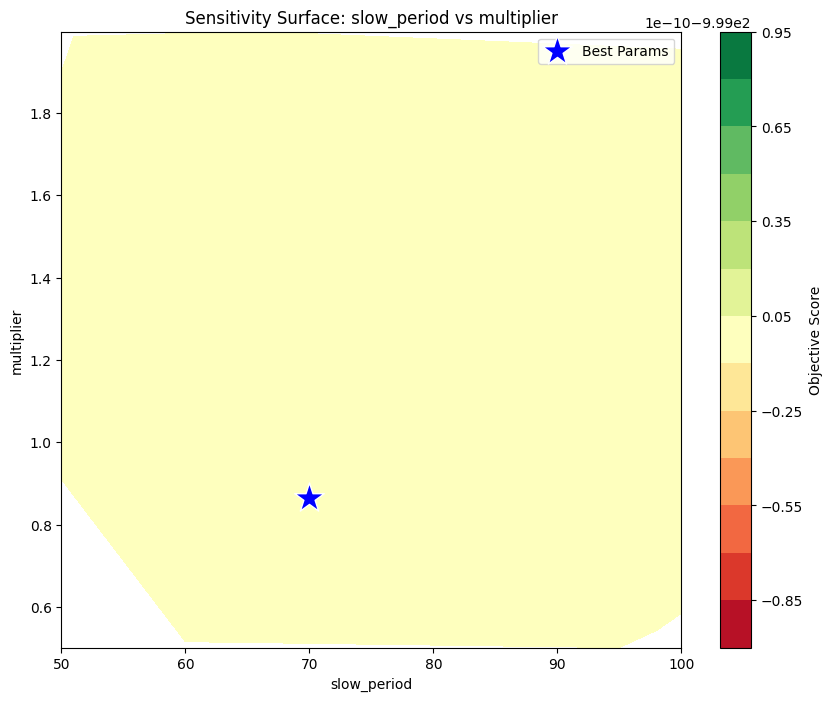

Results saved to wf_method2_results


In [12]:

param_space = get_mabw_param_space()


results_df, sensitivity_df = run_walkforward(
    data_dict=data_dict,
    param_space=param_space,
    strategy_class=MABWStrategy,
    strategy_name="MABWStrategy",
    trade_config=trade_config,
    wf_config=wf_config,
    objective_weights=(0.35, 0.65),  # 35% win rate, 65% Sharpe
    verbose=True
)


# Backtest on Holdout Dataset 

In [13]:
start_date = '2023-01-01'
raw_data = download_multiple(tickers, start_date)


  GS...  761 bars
  MSFT...  761 bars
  HD...  761 bars
  V...  761 bars
  SHW...  761 bars
  CAT...  761 bars
  MCD...  761 bars
  UNH...  761 bars
  AXP...  761 bars
Successfully downloaded 9/9 tickers



In [14]:
# Load configurations
strategy_config, trade_config, full_config = load_configs(
    f'{config_base_path}/configs/mabw_strategy.yaml',
    f'{config_base_path}/configs/default_settings.yaml'
)

In [15]:
strategy_config

StrategyConfig(name='MABW', parameters={'fast_period': 10, 'slow_period': 60, 'multiplier': 1.0, 'ema_period': 20, 'atr_period': 14, 'atr_multiplier': 3.0, 'mabw_llv_period': 10, 'mab_width_critical': 30})

In [16]:
trade_config

TradeConfig(initial_capital=100000, commission_pct=0.001, slippage_pct=0.0005, slippage_fixed=0.01, position_size_pct=0.95, max_trade_size=50000, min_trade_size=100)

In [17]:
trade_config.initial_capital = 300_000
trade_config.max_trade_size = 30_000
trade_config.min_trade_size = 10_000

In [18]:
trade_config

TradeConfig(initial_capital=300000, commission_pct=0.001, slippage_pct=0.0005, slippage_fixed=0.01, position_size_pct=0.95, max_trade_size=30000, min_trade_size=10000)

In [27]:
strategy_config.parameters = {'fast_period': 35, 'slow_period': 70, 'multiplier': 0.8635188801456073, 'ema_period': 37, 'mabw_llv_period': 15, 'mab_width_critical': 20, 'atr_period': 11, 'atr_multiplier': 2.8947422562204568}


In [28]:
aligned_data = align_data(raw_data)

print(f" Downloaded data for {len(tickers)} tickers")
if len(aligned_data) > 0:
    first_ticker = list(aligned_data.keys())[0]
    date_range = f"{aligned_data[first_ticker].index[0]} to {aligned_data[first_ticker].index[-1]}"
    print(f"   Date range: {date_range}")
    print(f"   Total bars per ticker: {len(aligned_data[first_ticker])}")

 Downloaded data for 9 tickers
   Date range: 2023-01-03 00:00:00 to 2026-01-14 00:00:00
   Total bars per ticker: 761


In [29]:
# Initialize strategy
print("\n Initializing strategy...")
strategy = MABWStrategy(strategy_config)

# Validate configuration
if not strategy.validate_config():
    print(" Invalid configuration!")



 Initializing strategy...


In [30]:
# Run backtest
print("\n Running backtest...")
engine = BacktestEngine(strategy, trade_config)
results = engine.run(aligned_data)

# Print results
print_performance_summary(results.metrics)



 Running backtest...

PERFORMANCE SUMMARY

*** RETURNS ***
  Initial Capital:    $  300,000.00
  Final Value:        $  387,560.93
  Total P&L:          $   87,560.93
  Total Return:              29.19%

*** RISK METRICS ***
  Sharpe Ratio:               0.92
  Sortino Ratio:              1.06
  Max Drawdown:             -14.43%
  Calmar Ratio:               2.02
  Annual Volatility:          9.77%

*** TRADE STATISTICS ***
  Total Trades:                  9
  Win Rate:                  77.78%
  Profit Factor:              6.97
  Expectancy:         $     9695.19
  Best Trade:         $    38553.80
  Worst Trade:        $   -13133.59
  Average Trade:      $     9695.19

*** COSTS ***
  Total Commission:   $        0.00
  Total Slippage:     $        0.00
  Total Costs:        $        0.00




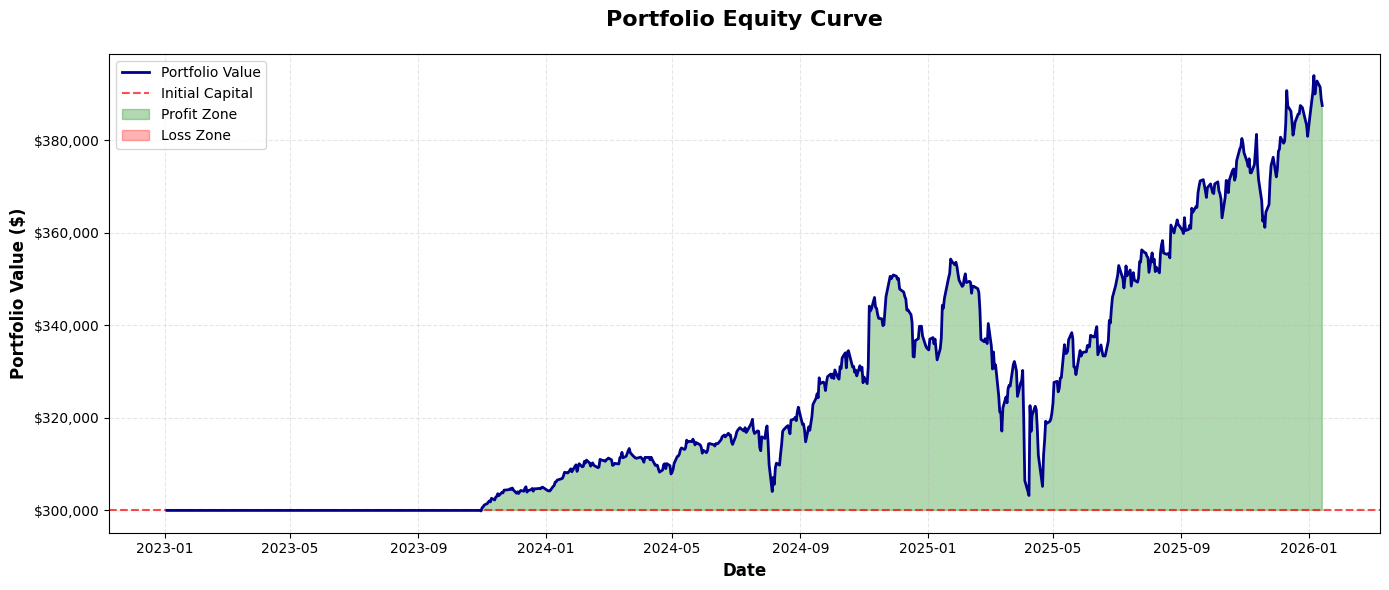

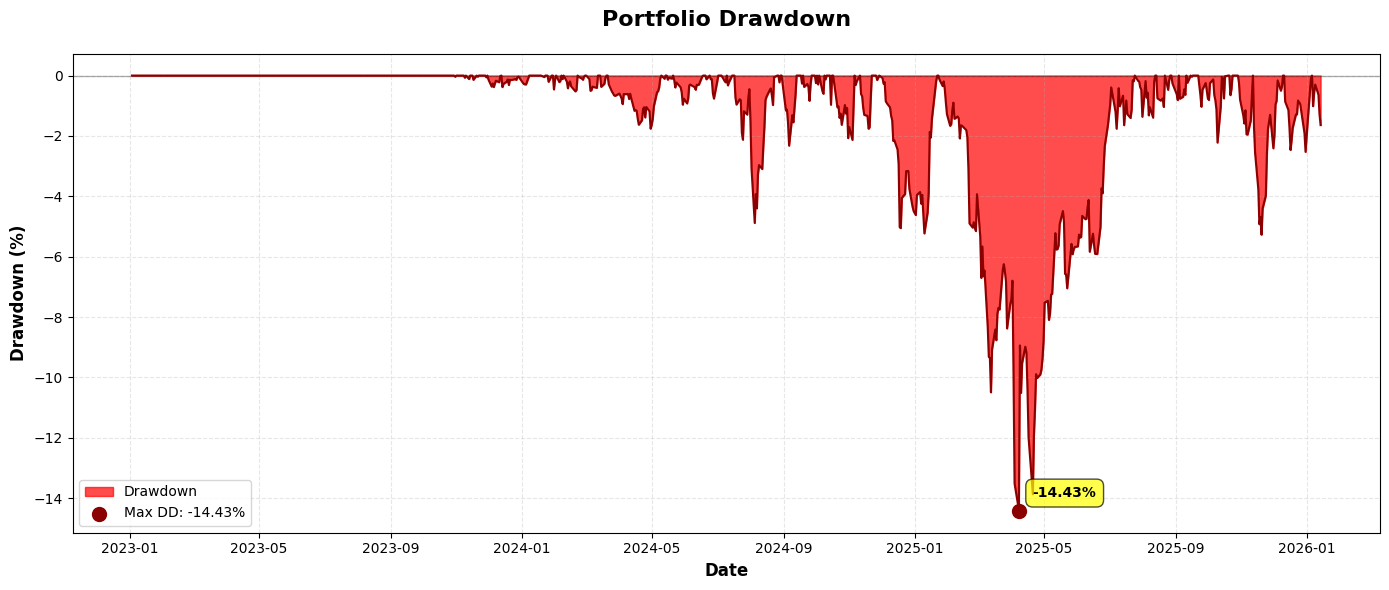

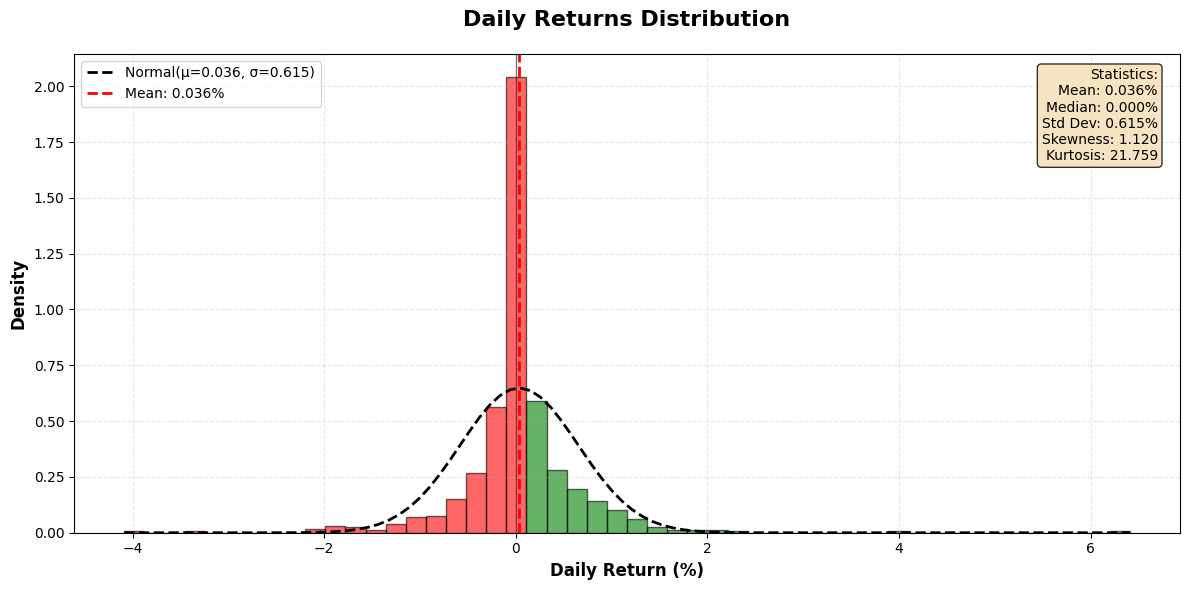

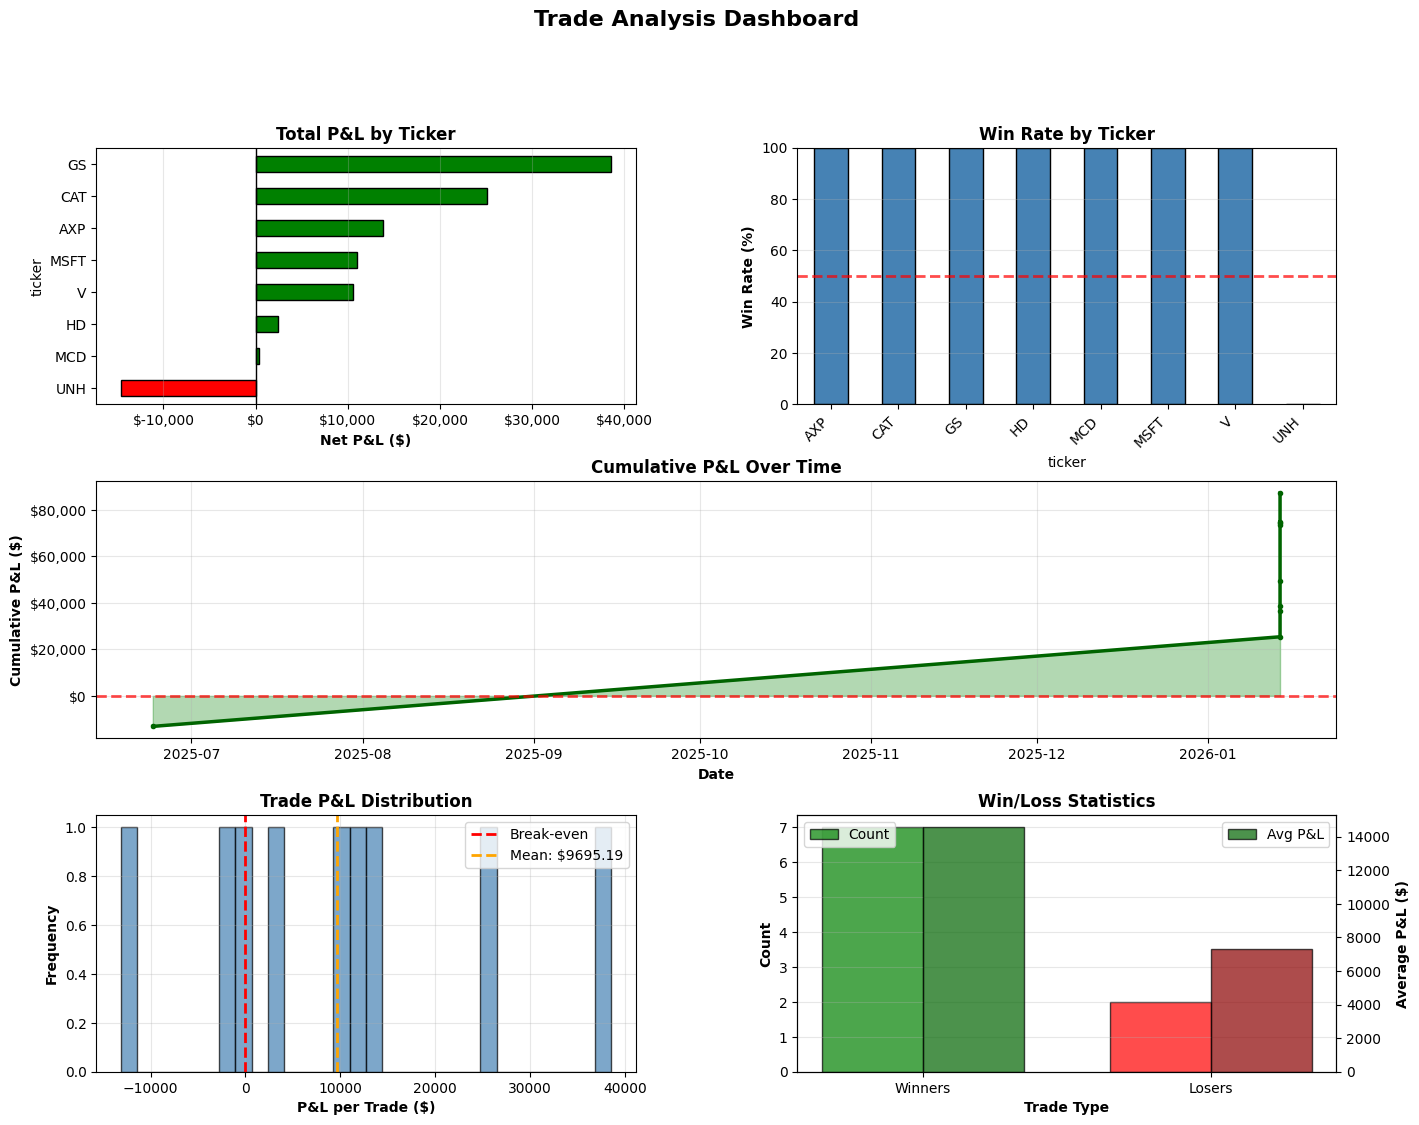

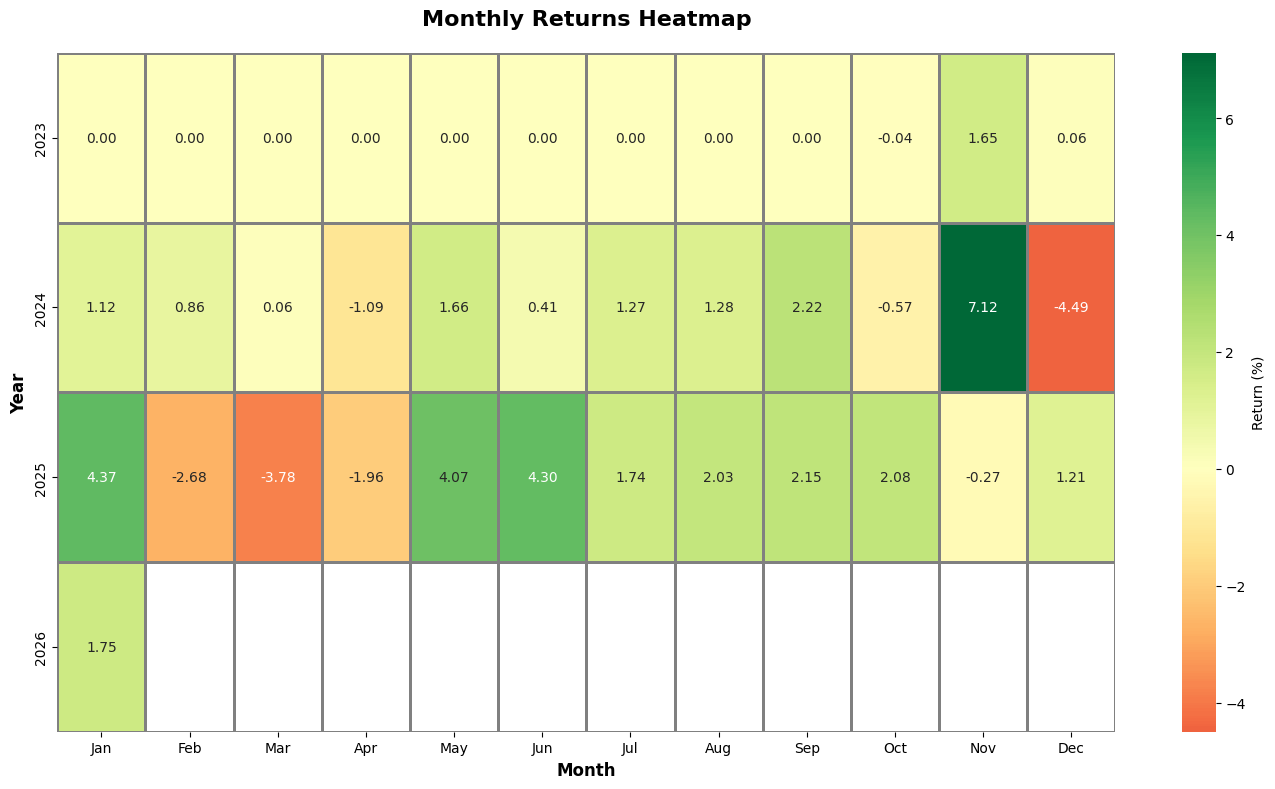

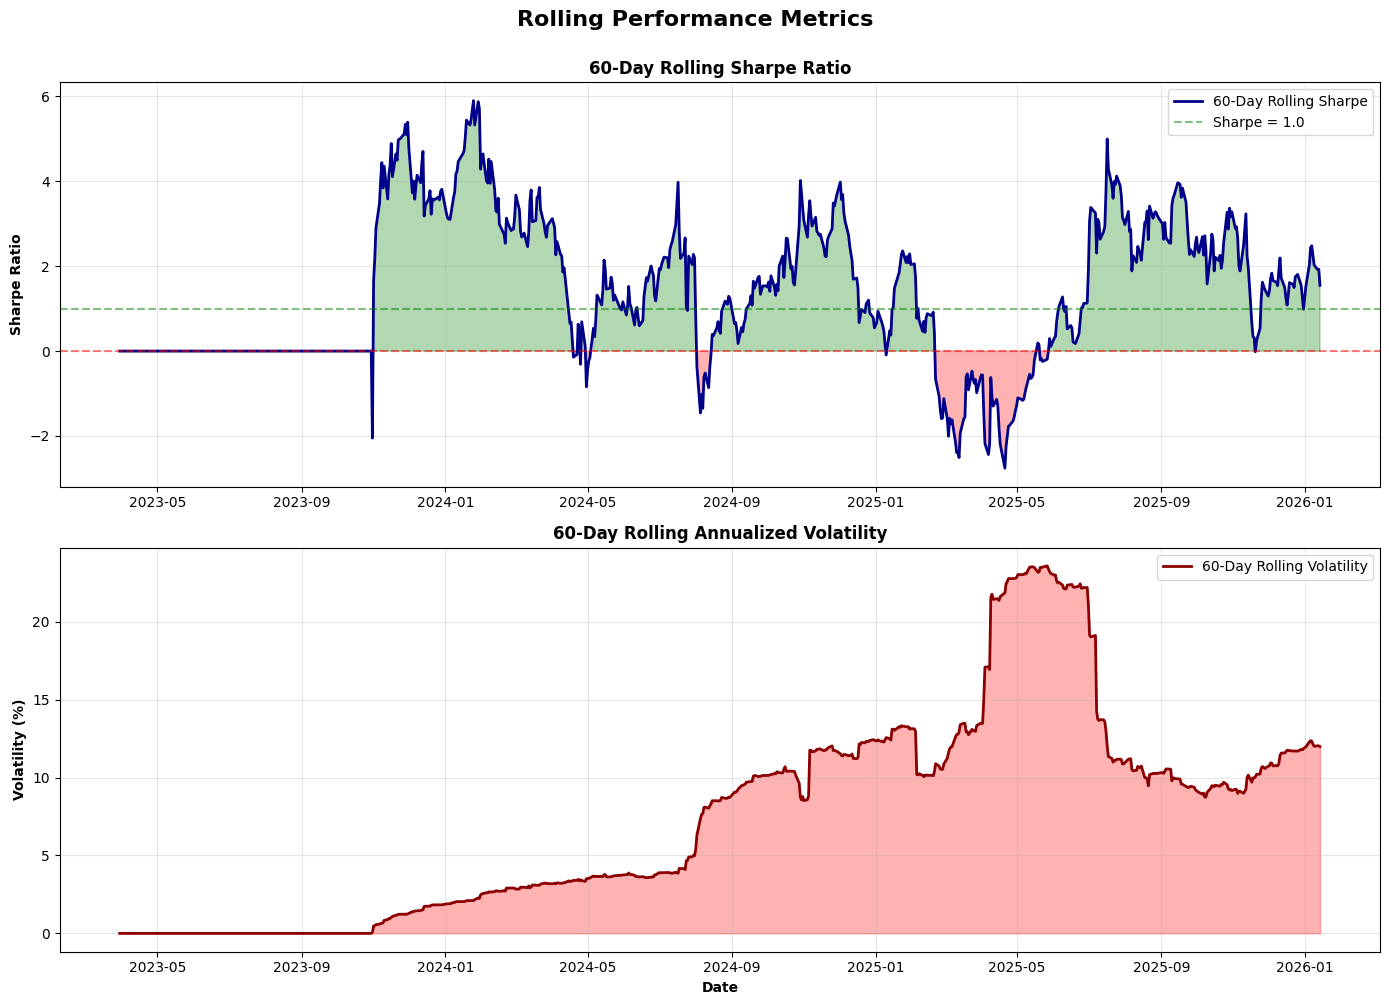

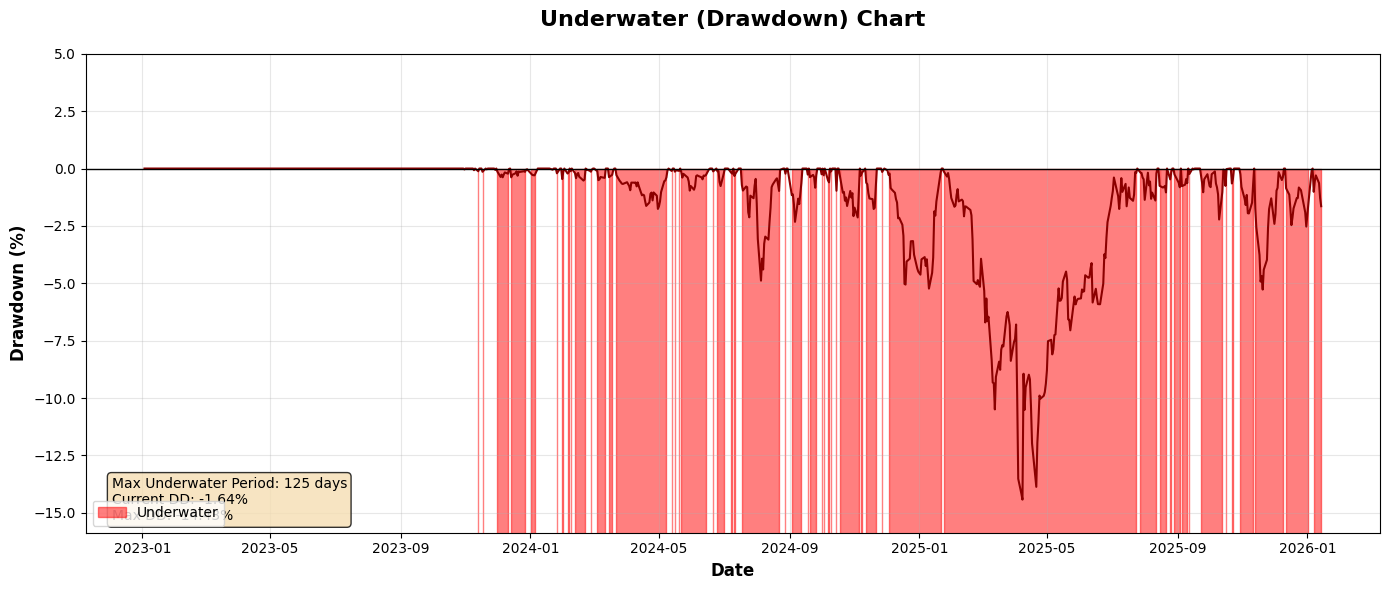

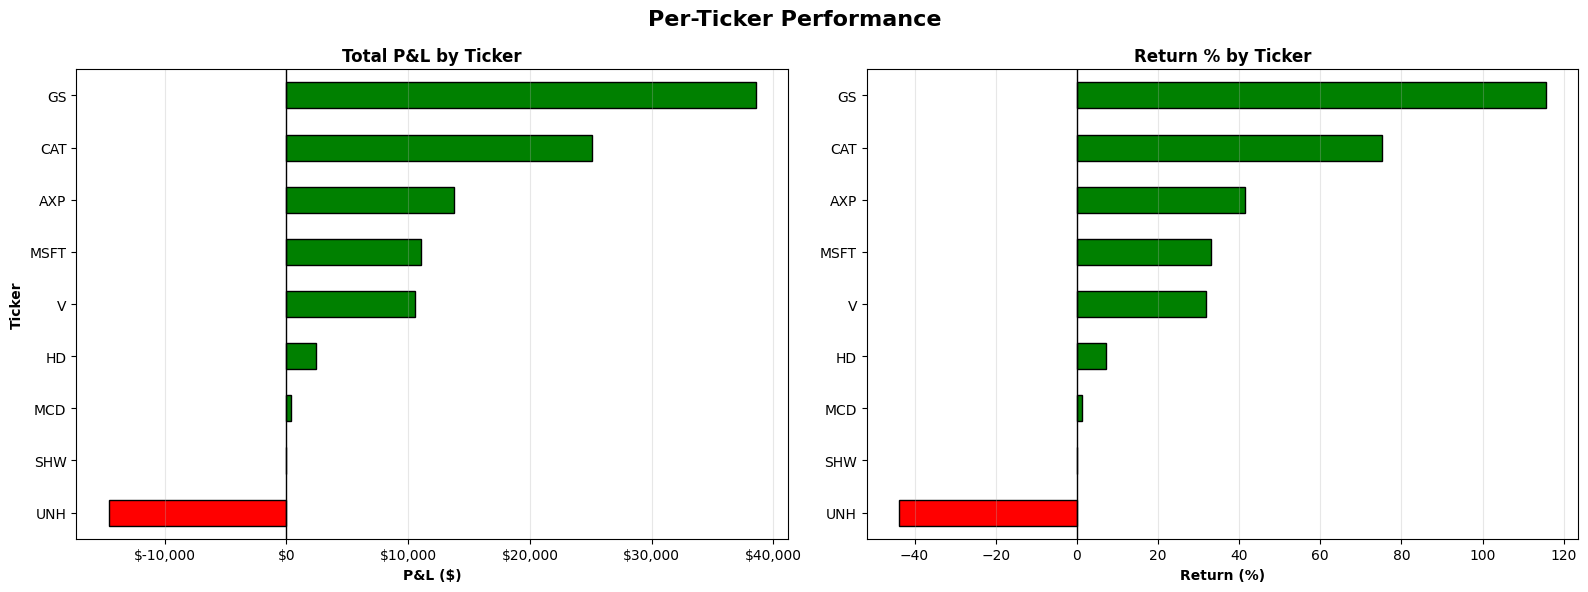

In [31]:
plot_performance_dashboard(results.portfolio_state, trade_config.initial_capital)

In [32]:
# Prepare data with indicators (SAVE THIS!)
prepared_data = {}
for ticker, df in aligned_data.items():
    prepared = strategy.prepare_data(df)
    prepared['ticker'] = ticker
    prepared_data[ticker] = prepared


MABW STRATEGY SIGNALS FOR UNH
Period: 2023-01-01 to 2025-12-31


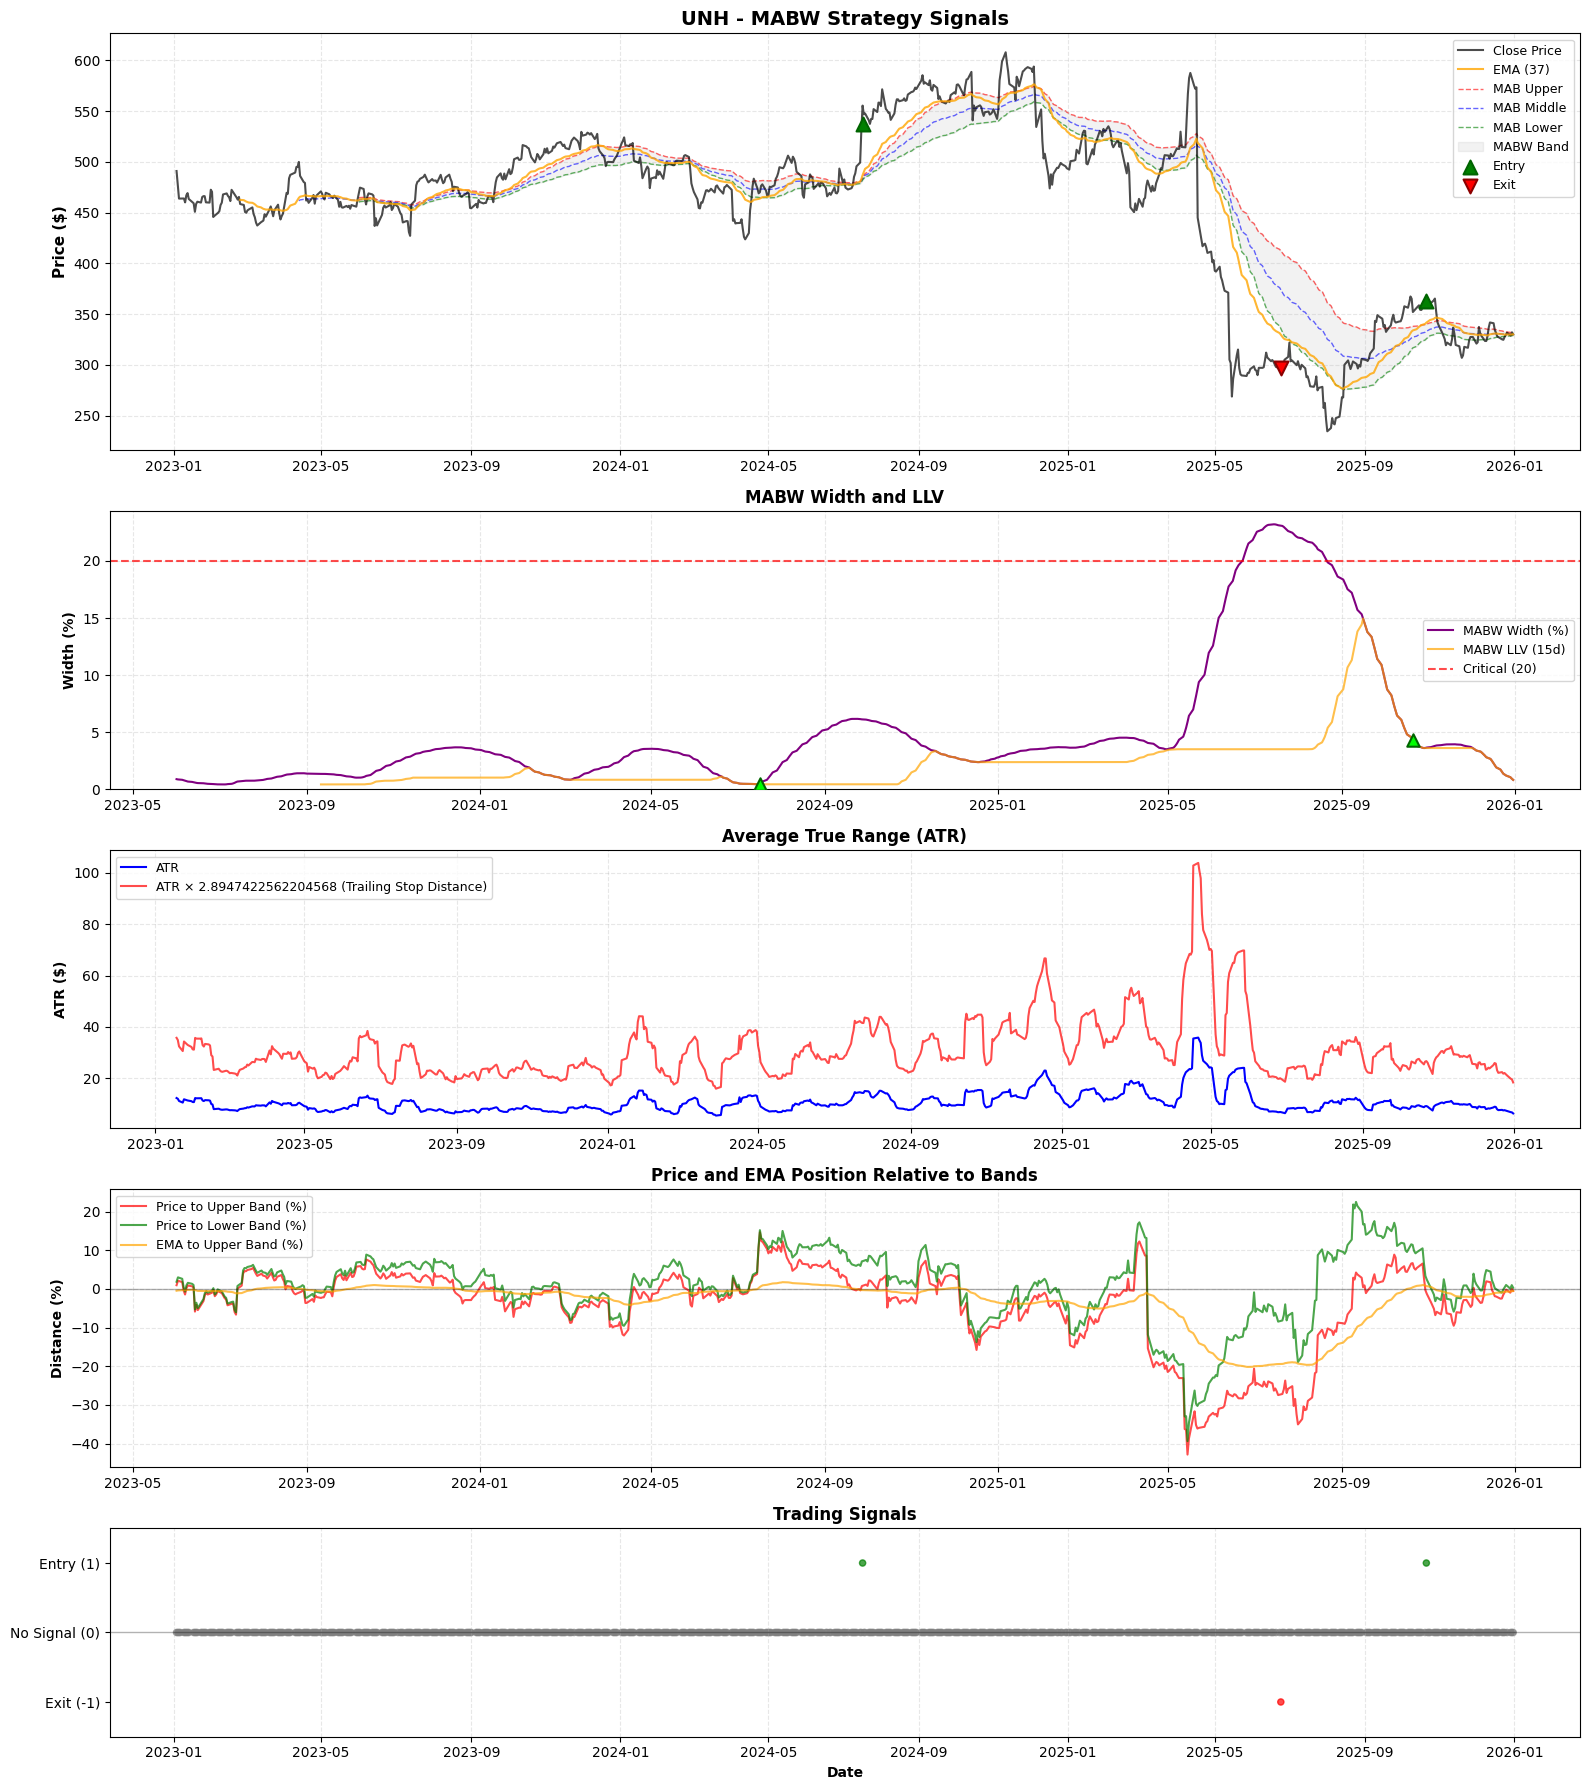


MABW Strategy Statistics for UNH:
--------------------------------------------------------------------------------
  Total Entry Signals: 2
  Total Exit Signals: 1

  Trade Performance:
    Total P&L: $-13,133.59
    Wins: 0 | Losses: 1
    Win Rate: 0.0%
    Avg Loss: $-13,133.59


In [33]:
plot_mabw_signals(
    data=prepared_data['UNH'],
    ticker='UNH',
    results=results,
    start_date='2023-01-01',
    end_date='2025-12-31',
    strategy_config=strategy_config
)



MABW STRATEGY SIGNALS FOR GS
Period: 2023-01-01 to 2025-12-31


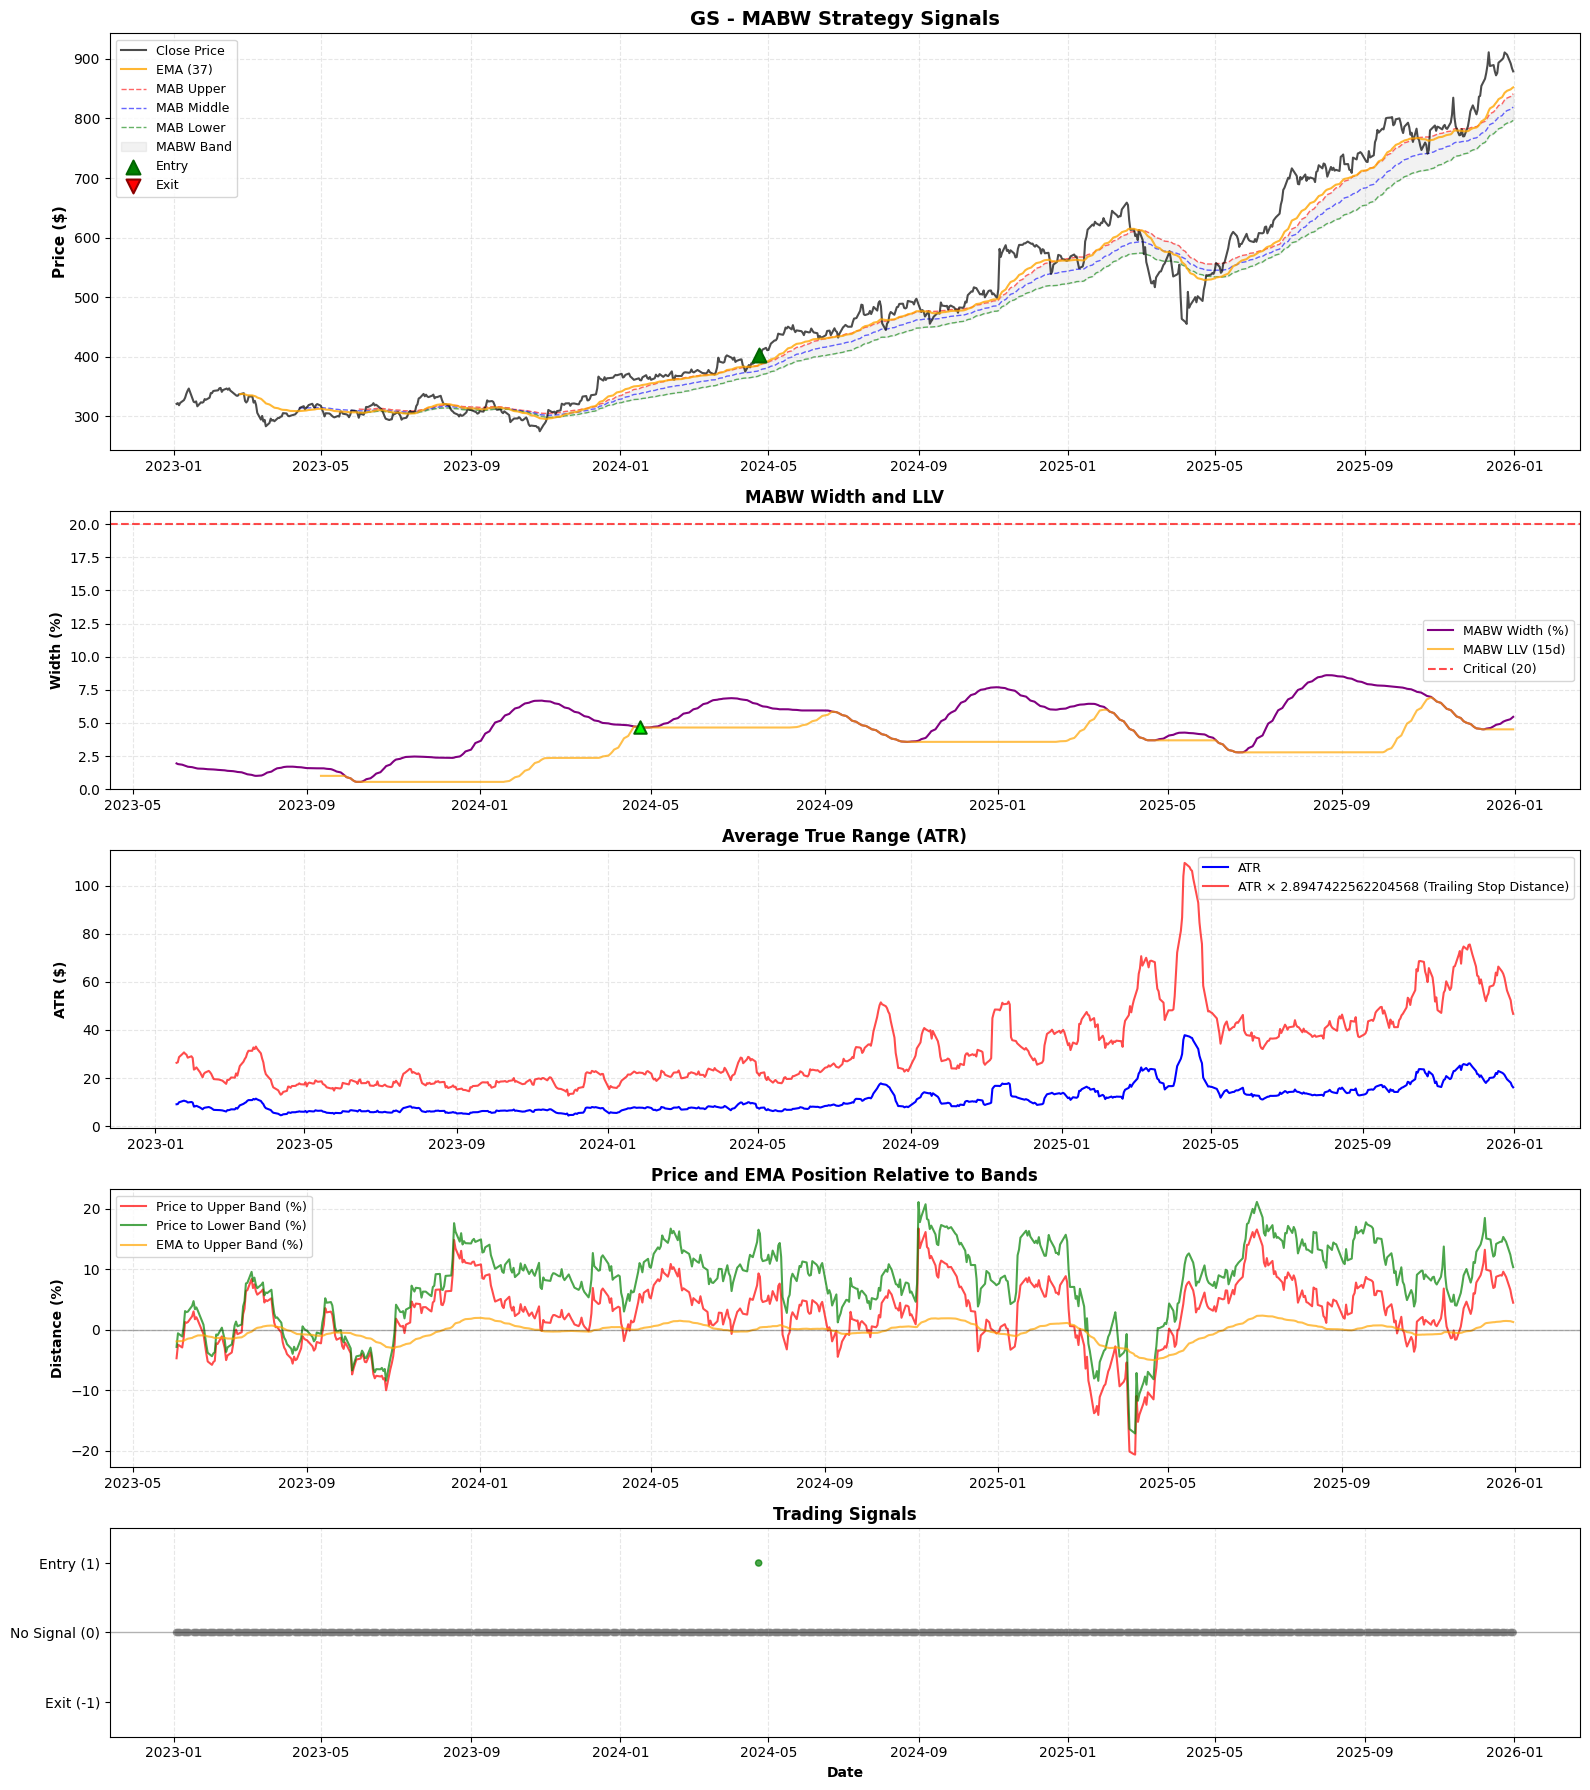


MABW Strategy Statistics for GS:
--------------------------------------------------------------------------------
  Total Entry Signals: 1
  Total Exit Signals: 0

MABW STRATEGY SIGNALS FOR MSFT
Period: 2023-01-01 to 2025-12-31


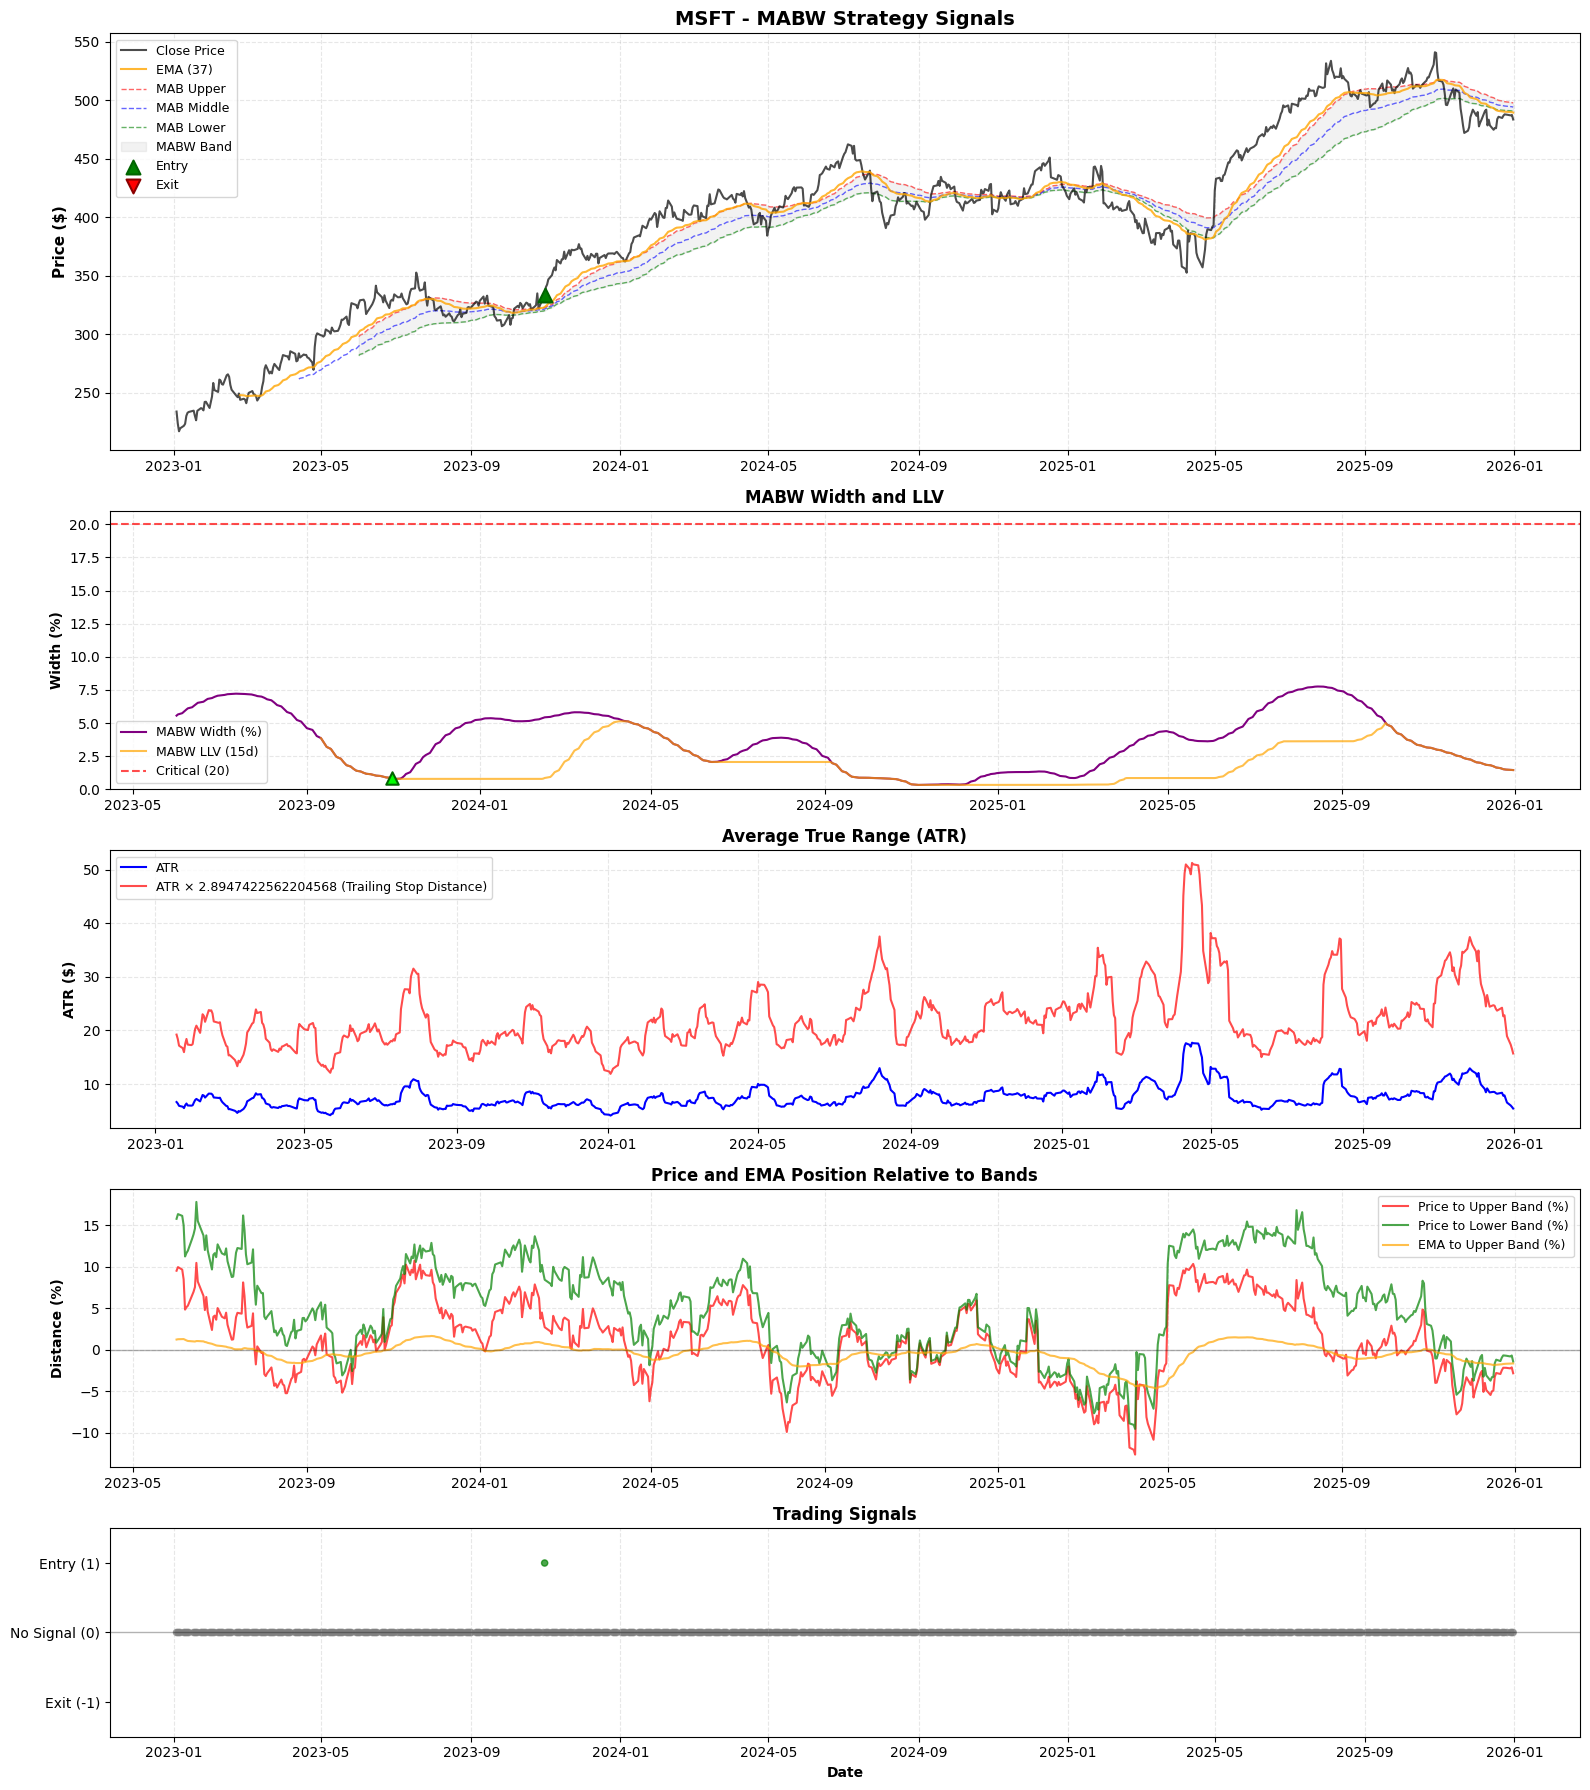


MABW Strategy Statistics for MSFT:
--------------------------------------------------------------------------------
  Total Entry Signals: 1
  Total Exit Signals: 0

MABW STRATEGY SIGNALS FOR HD
Period: 2023-01-01 to 2025-12-31


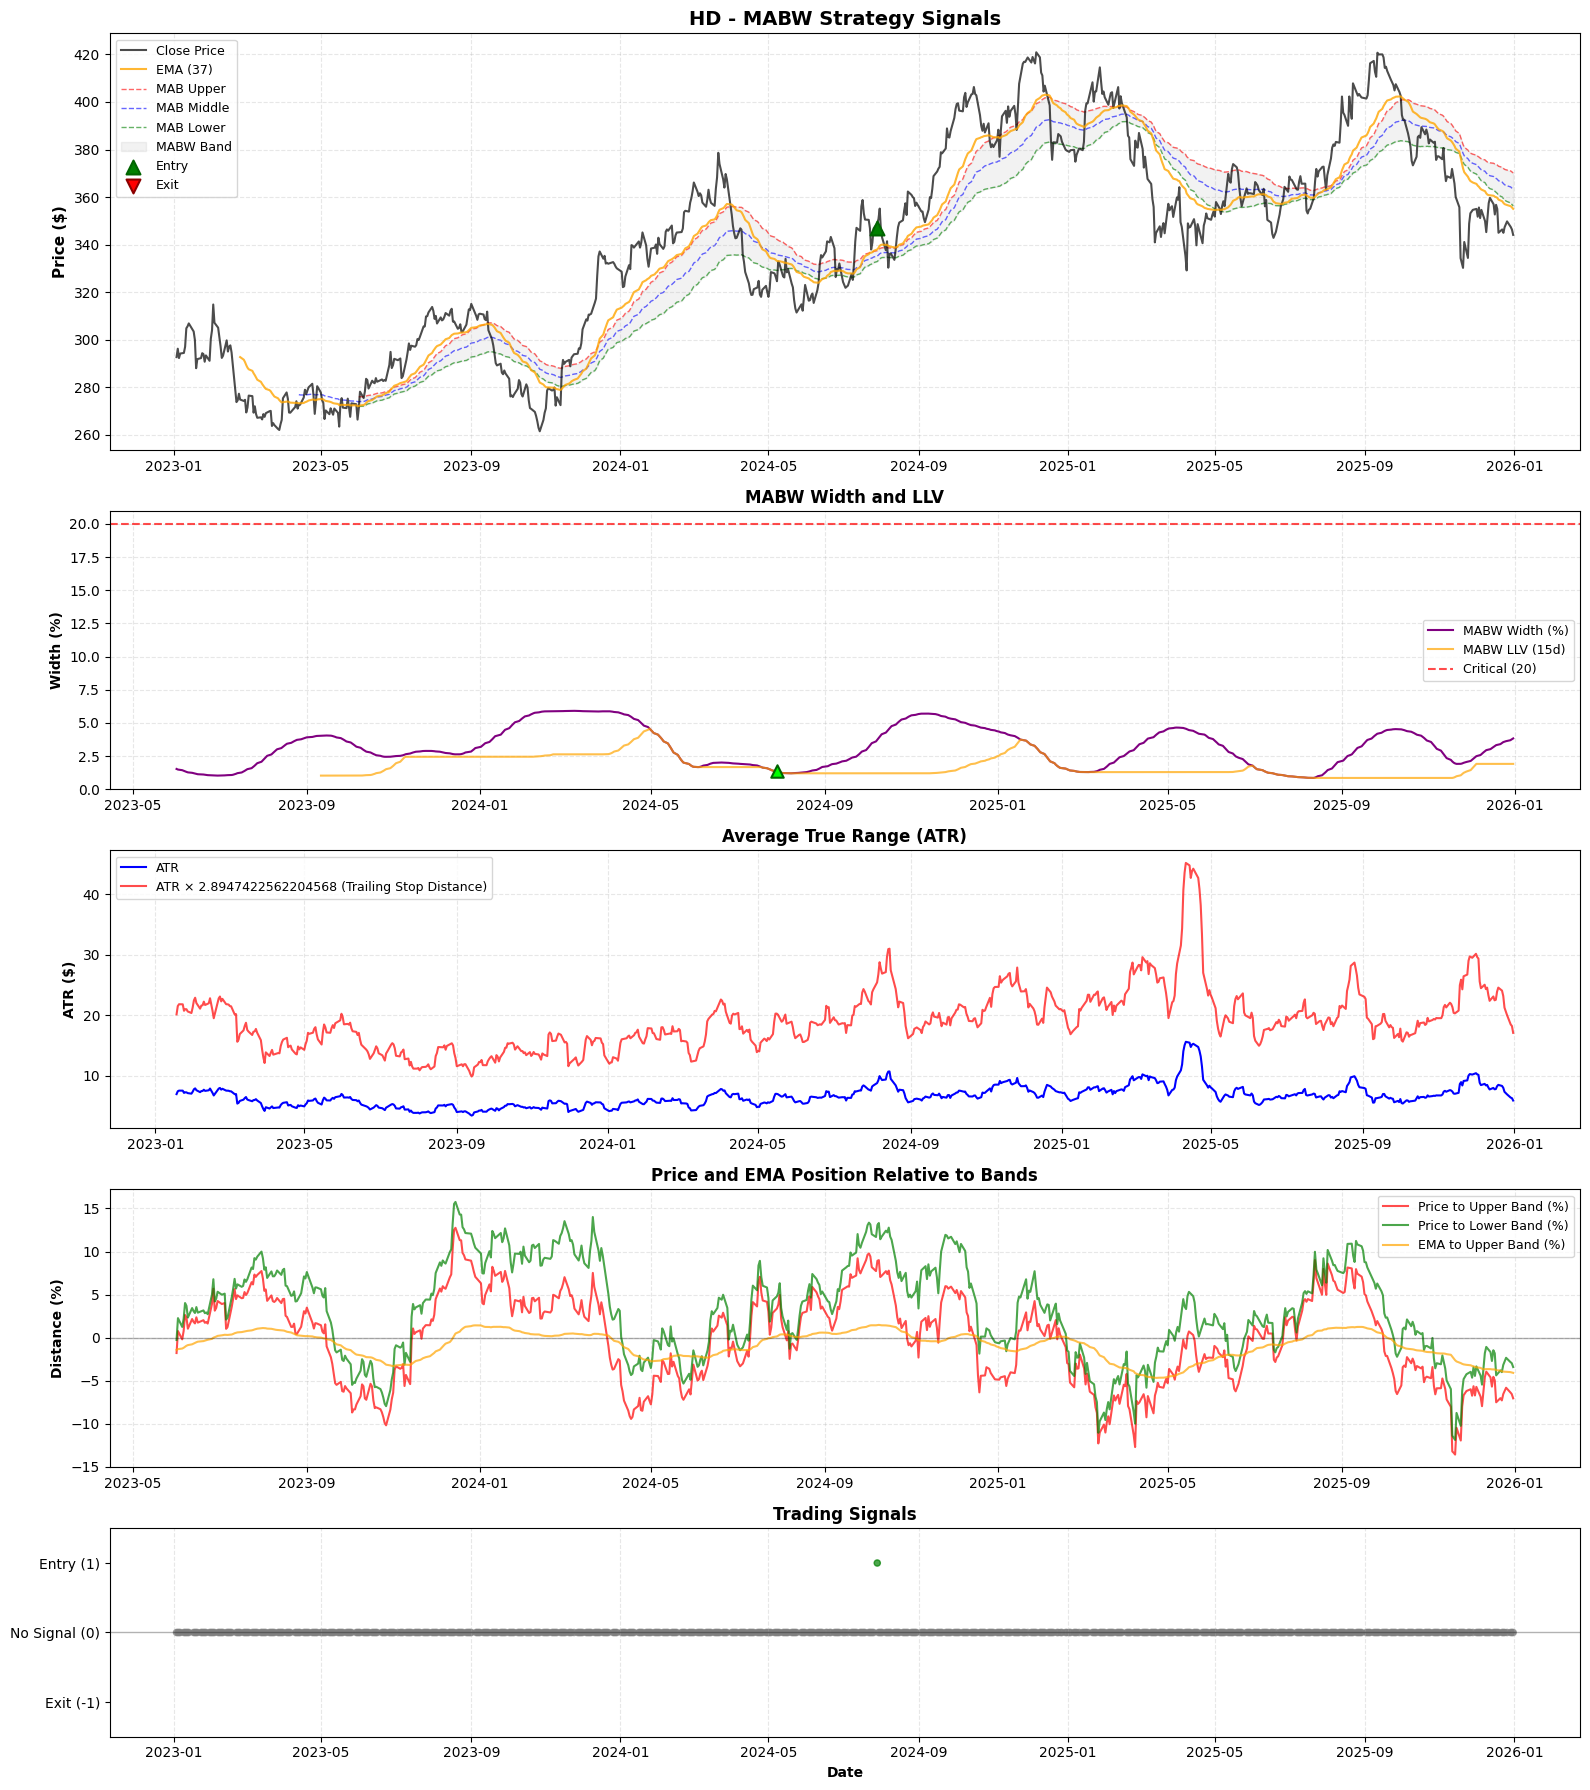


MABW Strategy Statistics for HD:
--------------------------------------------------------------------------------
  Total Entry Signals: 1
  Total Exit Signals: 0

MABW STRATEGY SIGNALS FOR V
Period: 2023-01-01 to 2025-12-31


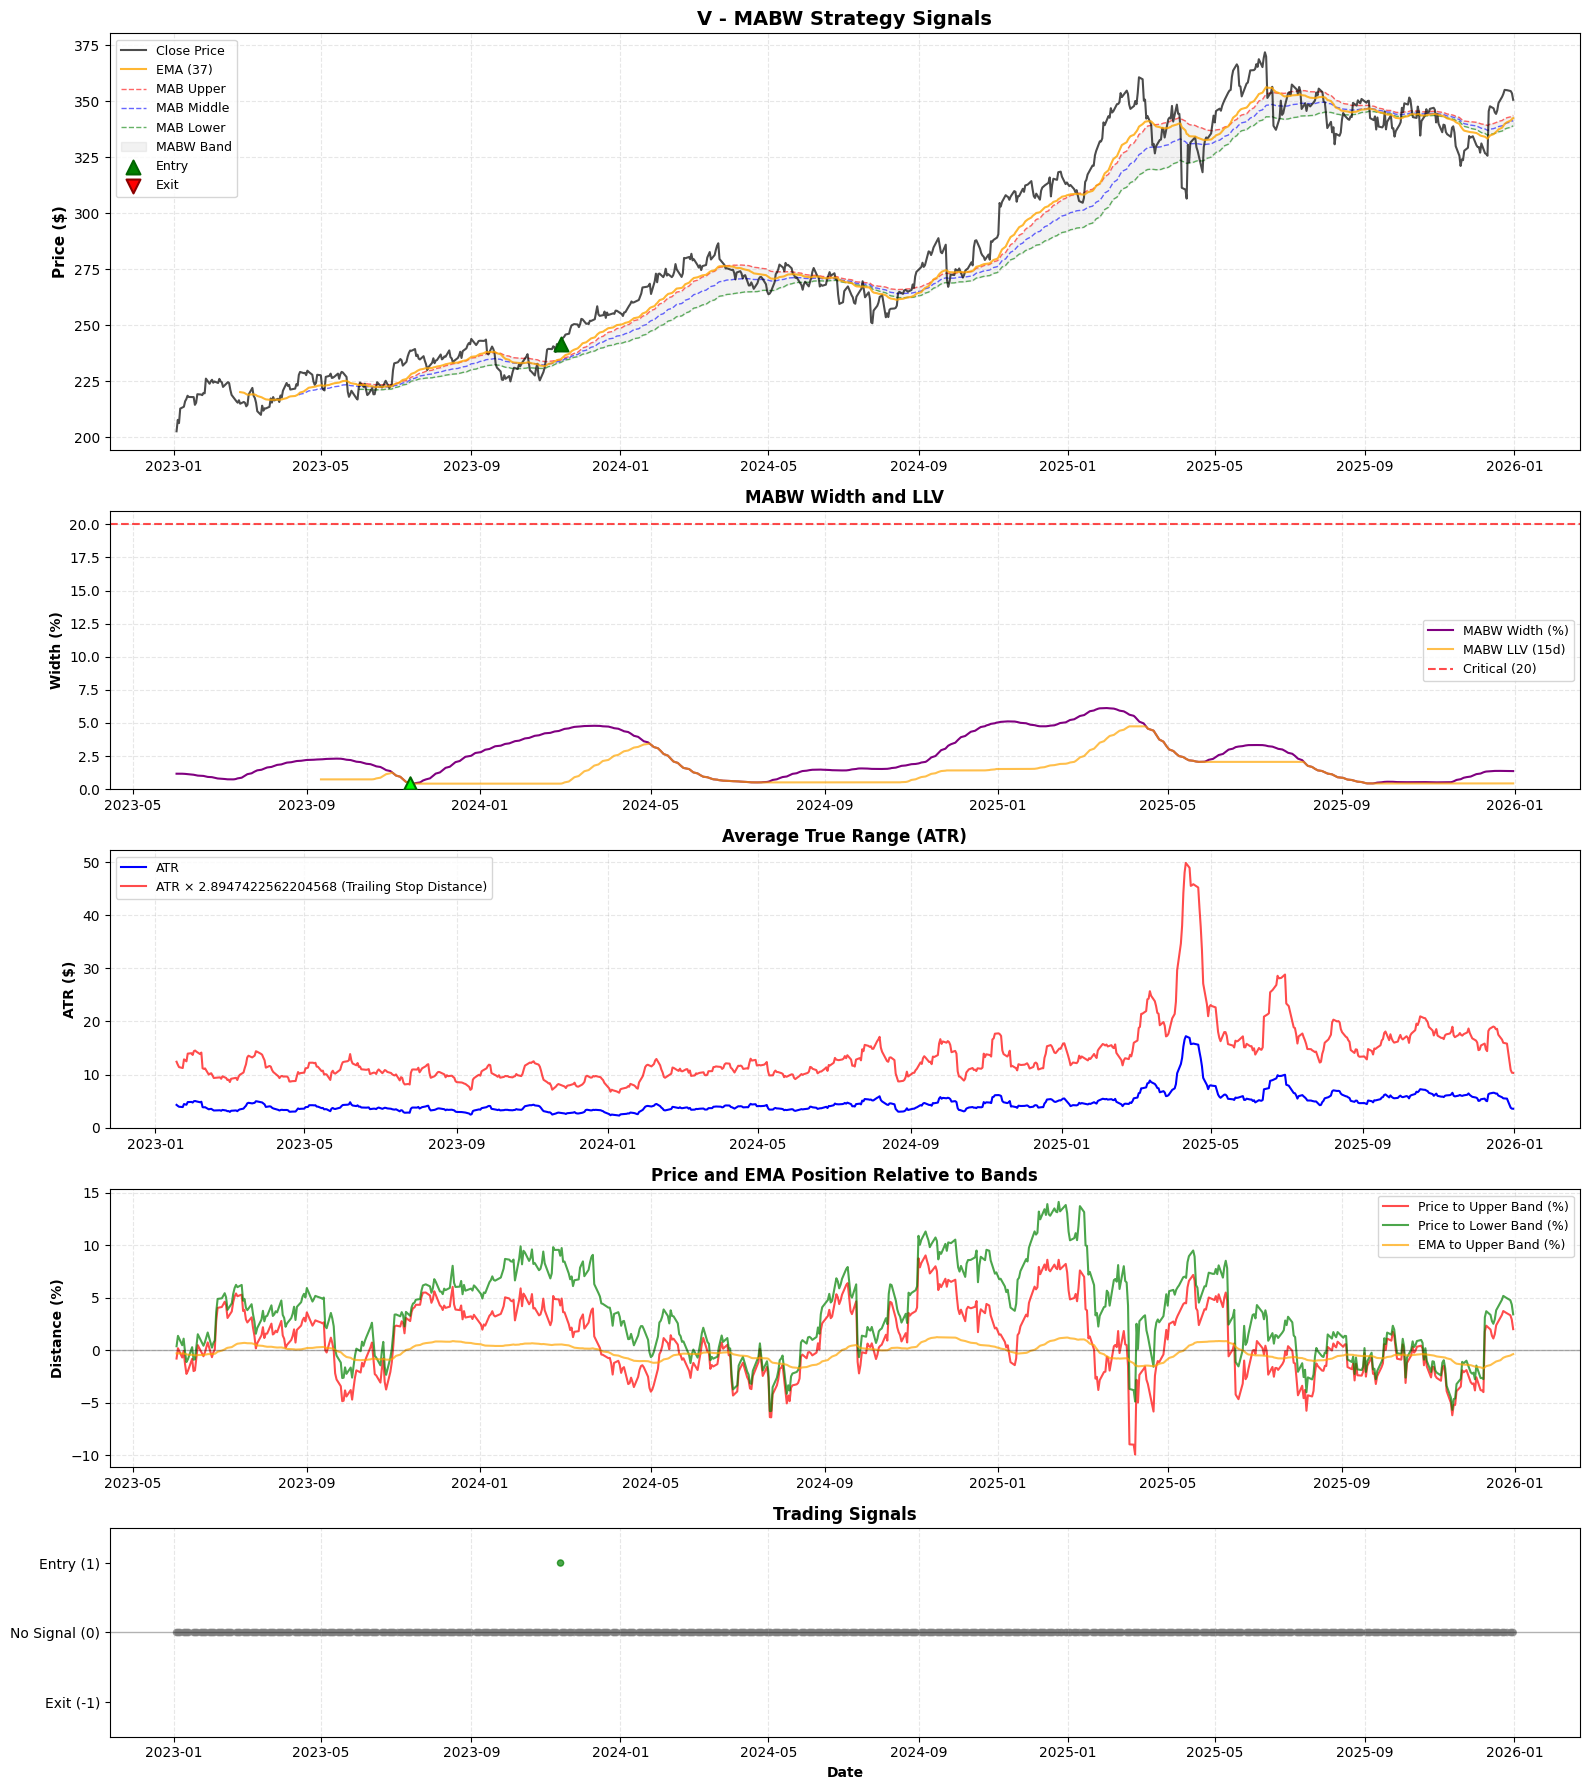


MABW Strategy Statistics for V:
--------------------------------------------------------------------------------
  Total Entry Signals: 1
  Total Exit Signals: 0

MABW STRATEGY SIGNALS FOR SHW
Period: 2023-01-01 to 2025-12-31


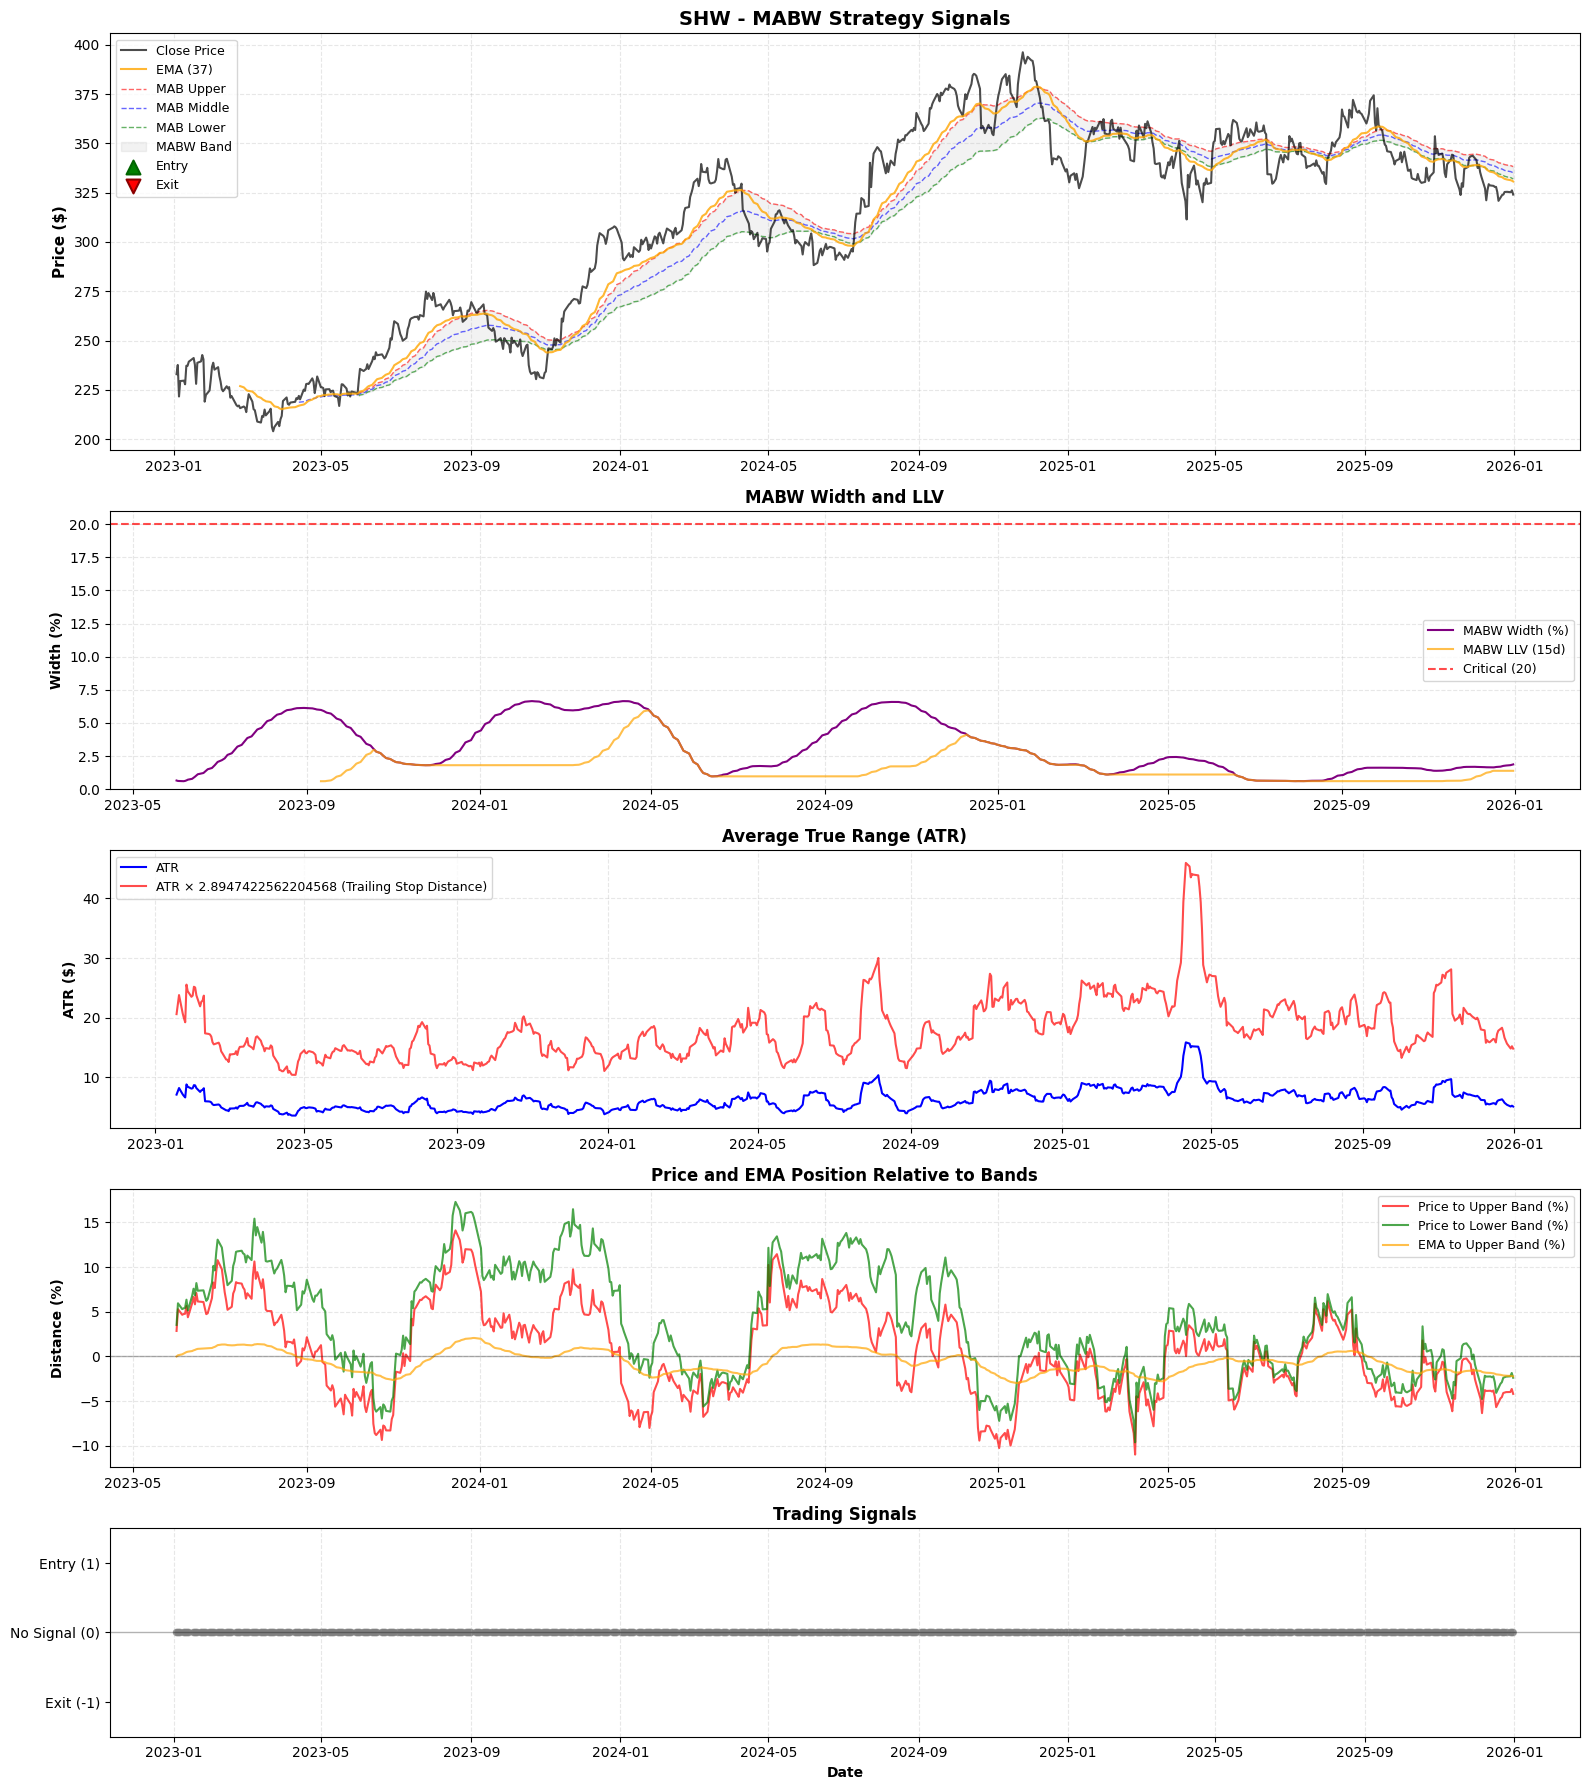


MABW Strategy Statistics for SHW:
--------------------------------------------------------------------------------
  Total Entry Signals: 0
  Total Exit Signals: 0

MABW STRATEGY SIGNALS FOR CAT
Period: 2023-01-01 to 2025-12-31


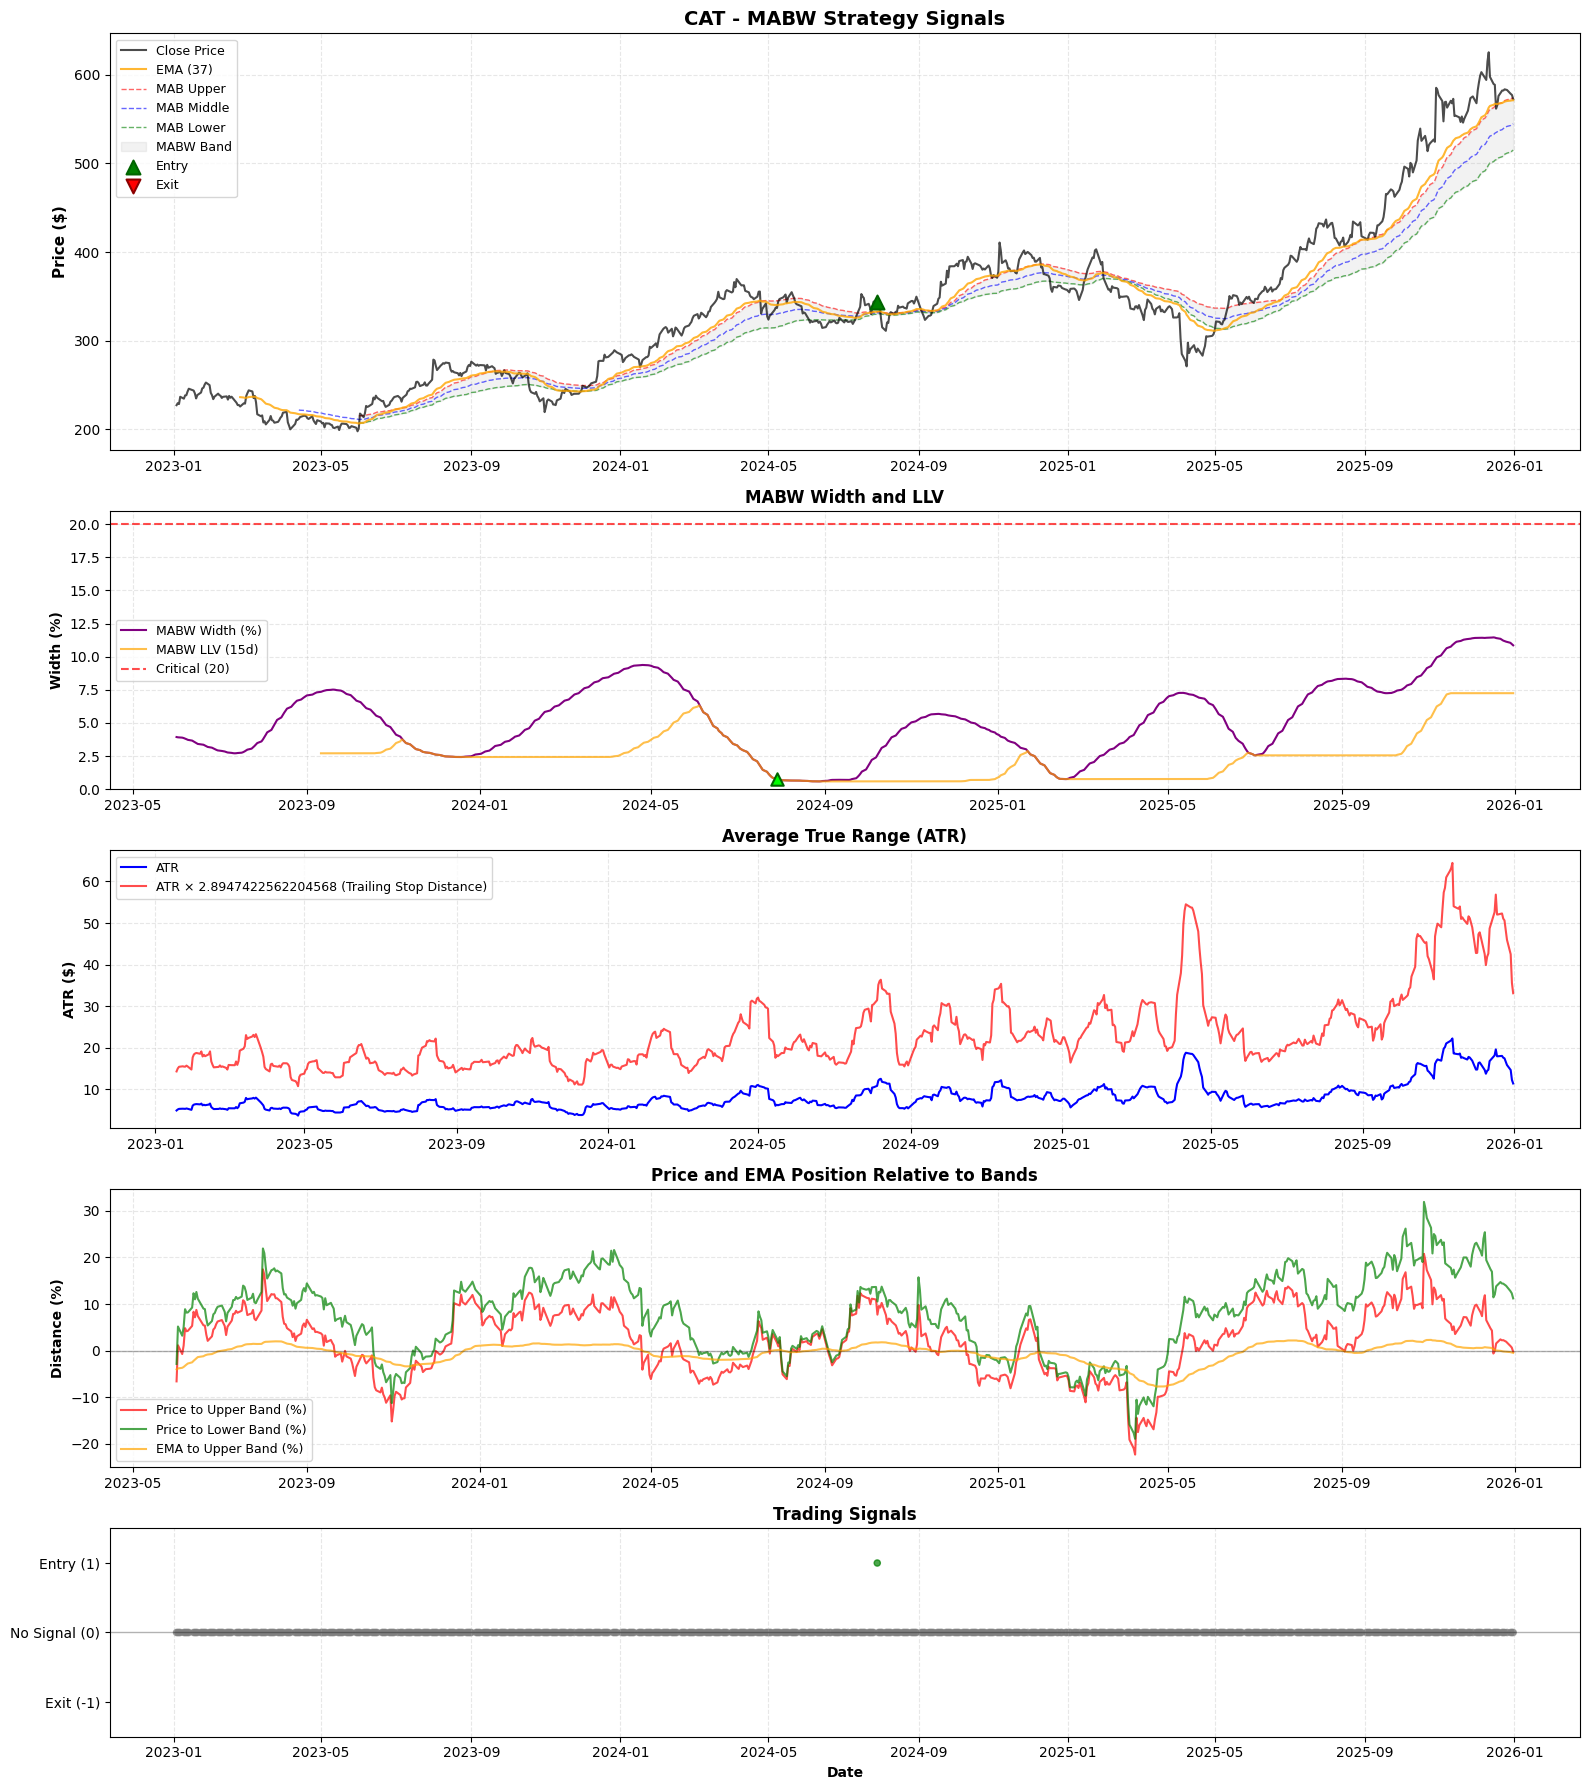


MABW Strategy Statistics for CAT:
--------------------------------------------------------------------------------
  Total Entry Signals: 1
  Total Exit Signals: 0

MABW STRATEGY SIGNALS FOR MCD
Period: 2023-01-01 to 2025-12-31


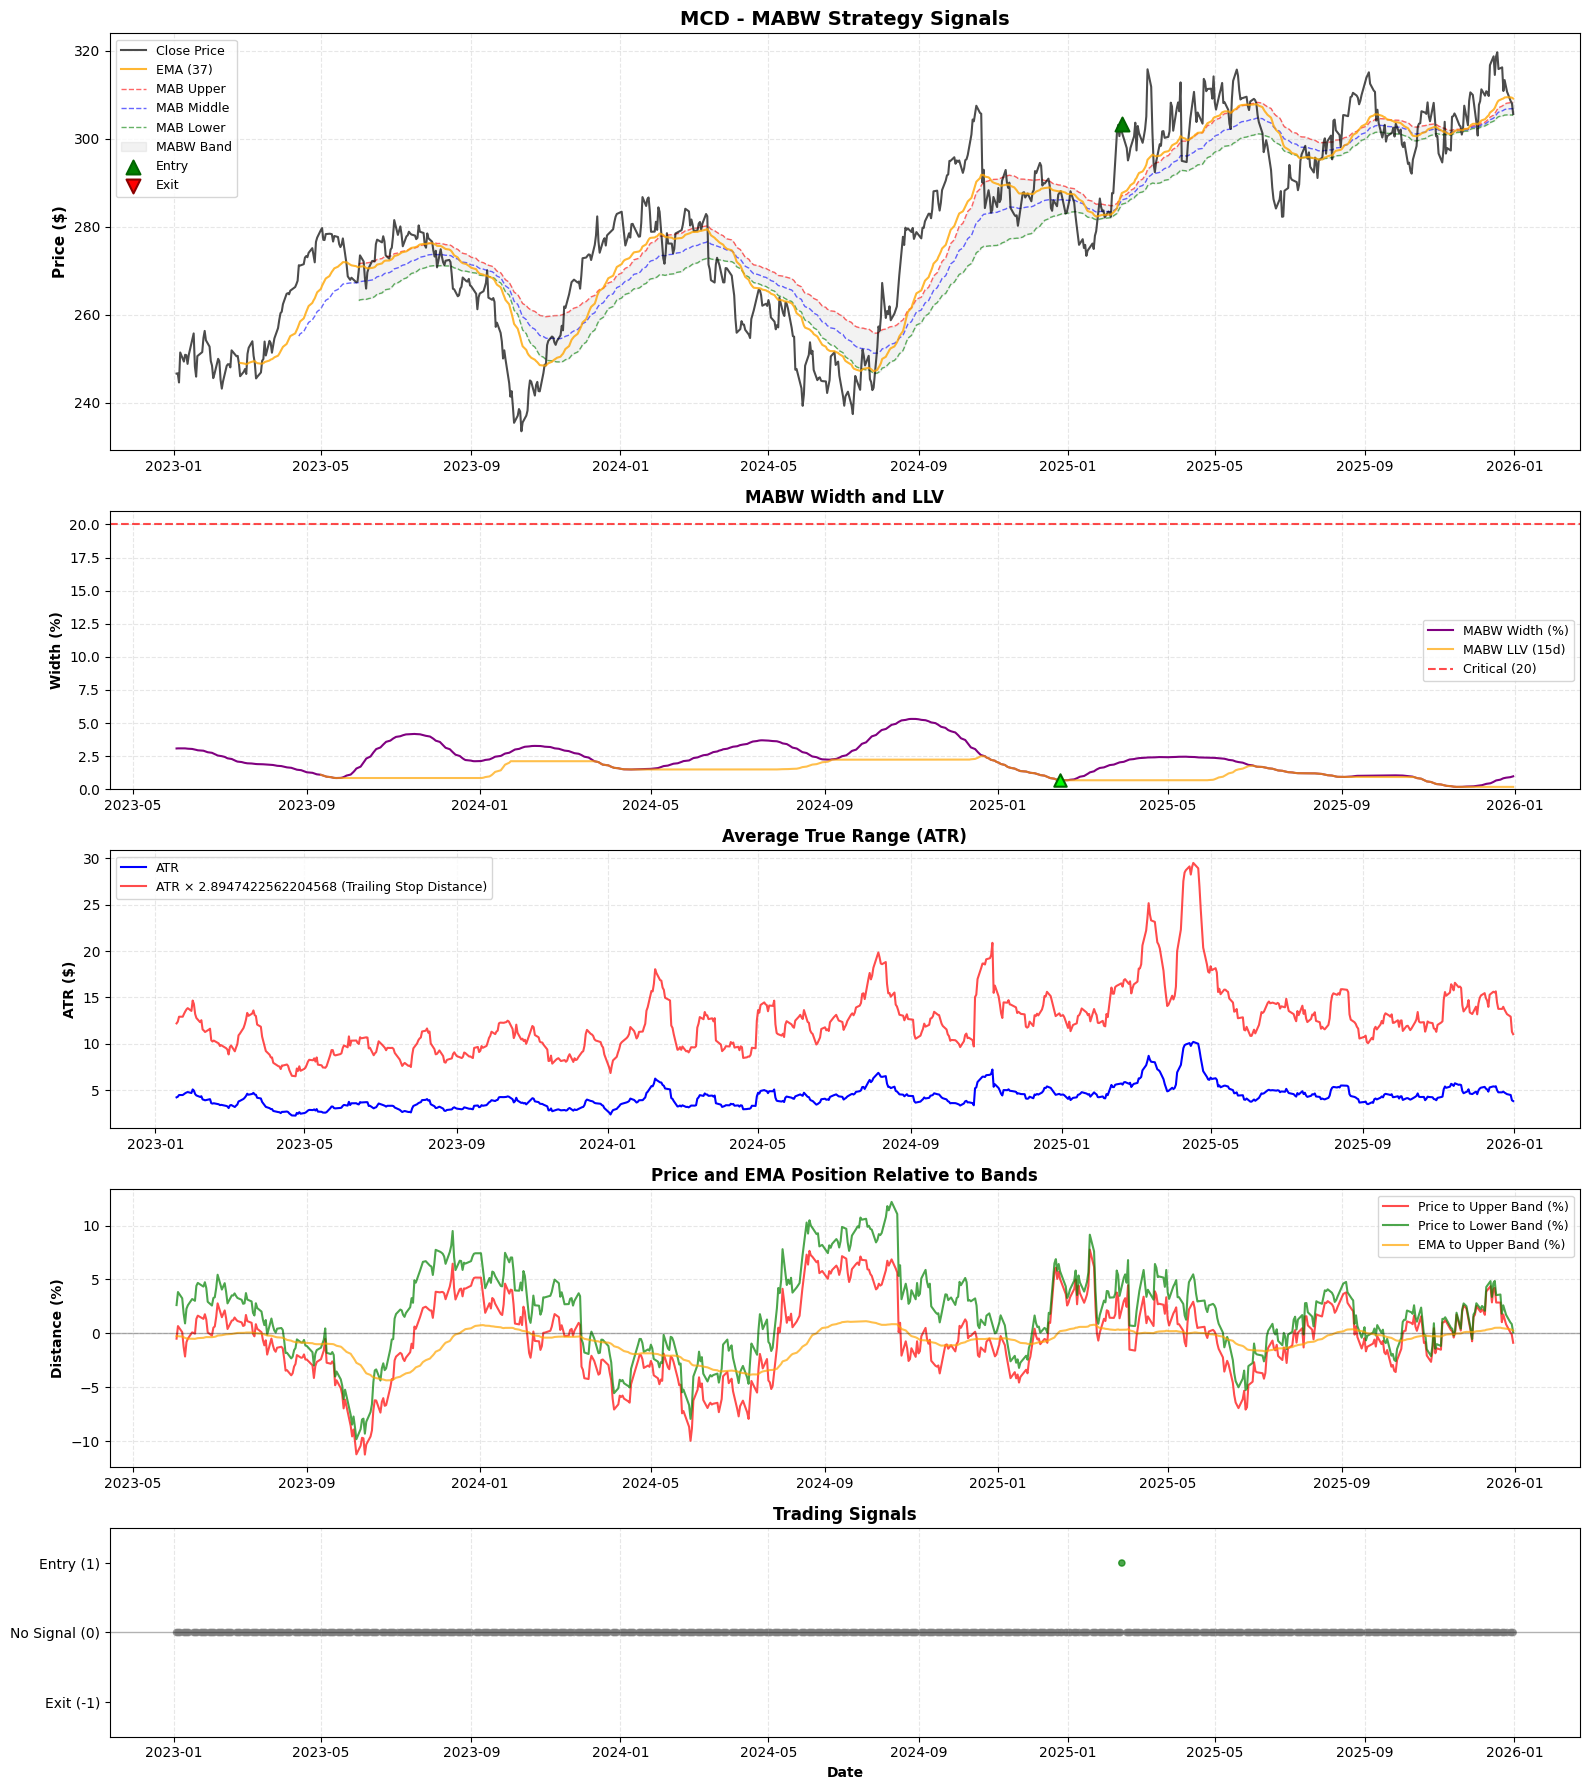


MABW Strategy Statistics for MCD:
--------------------------------------------------------------------------------
  Total Entry Signals: 1
  Total Exit Signals: 0

MABW STRATEGY SIGNALS FOR UNH
Period: 2023-01-01 to 2025-12-31


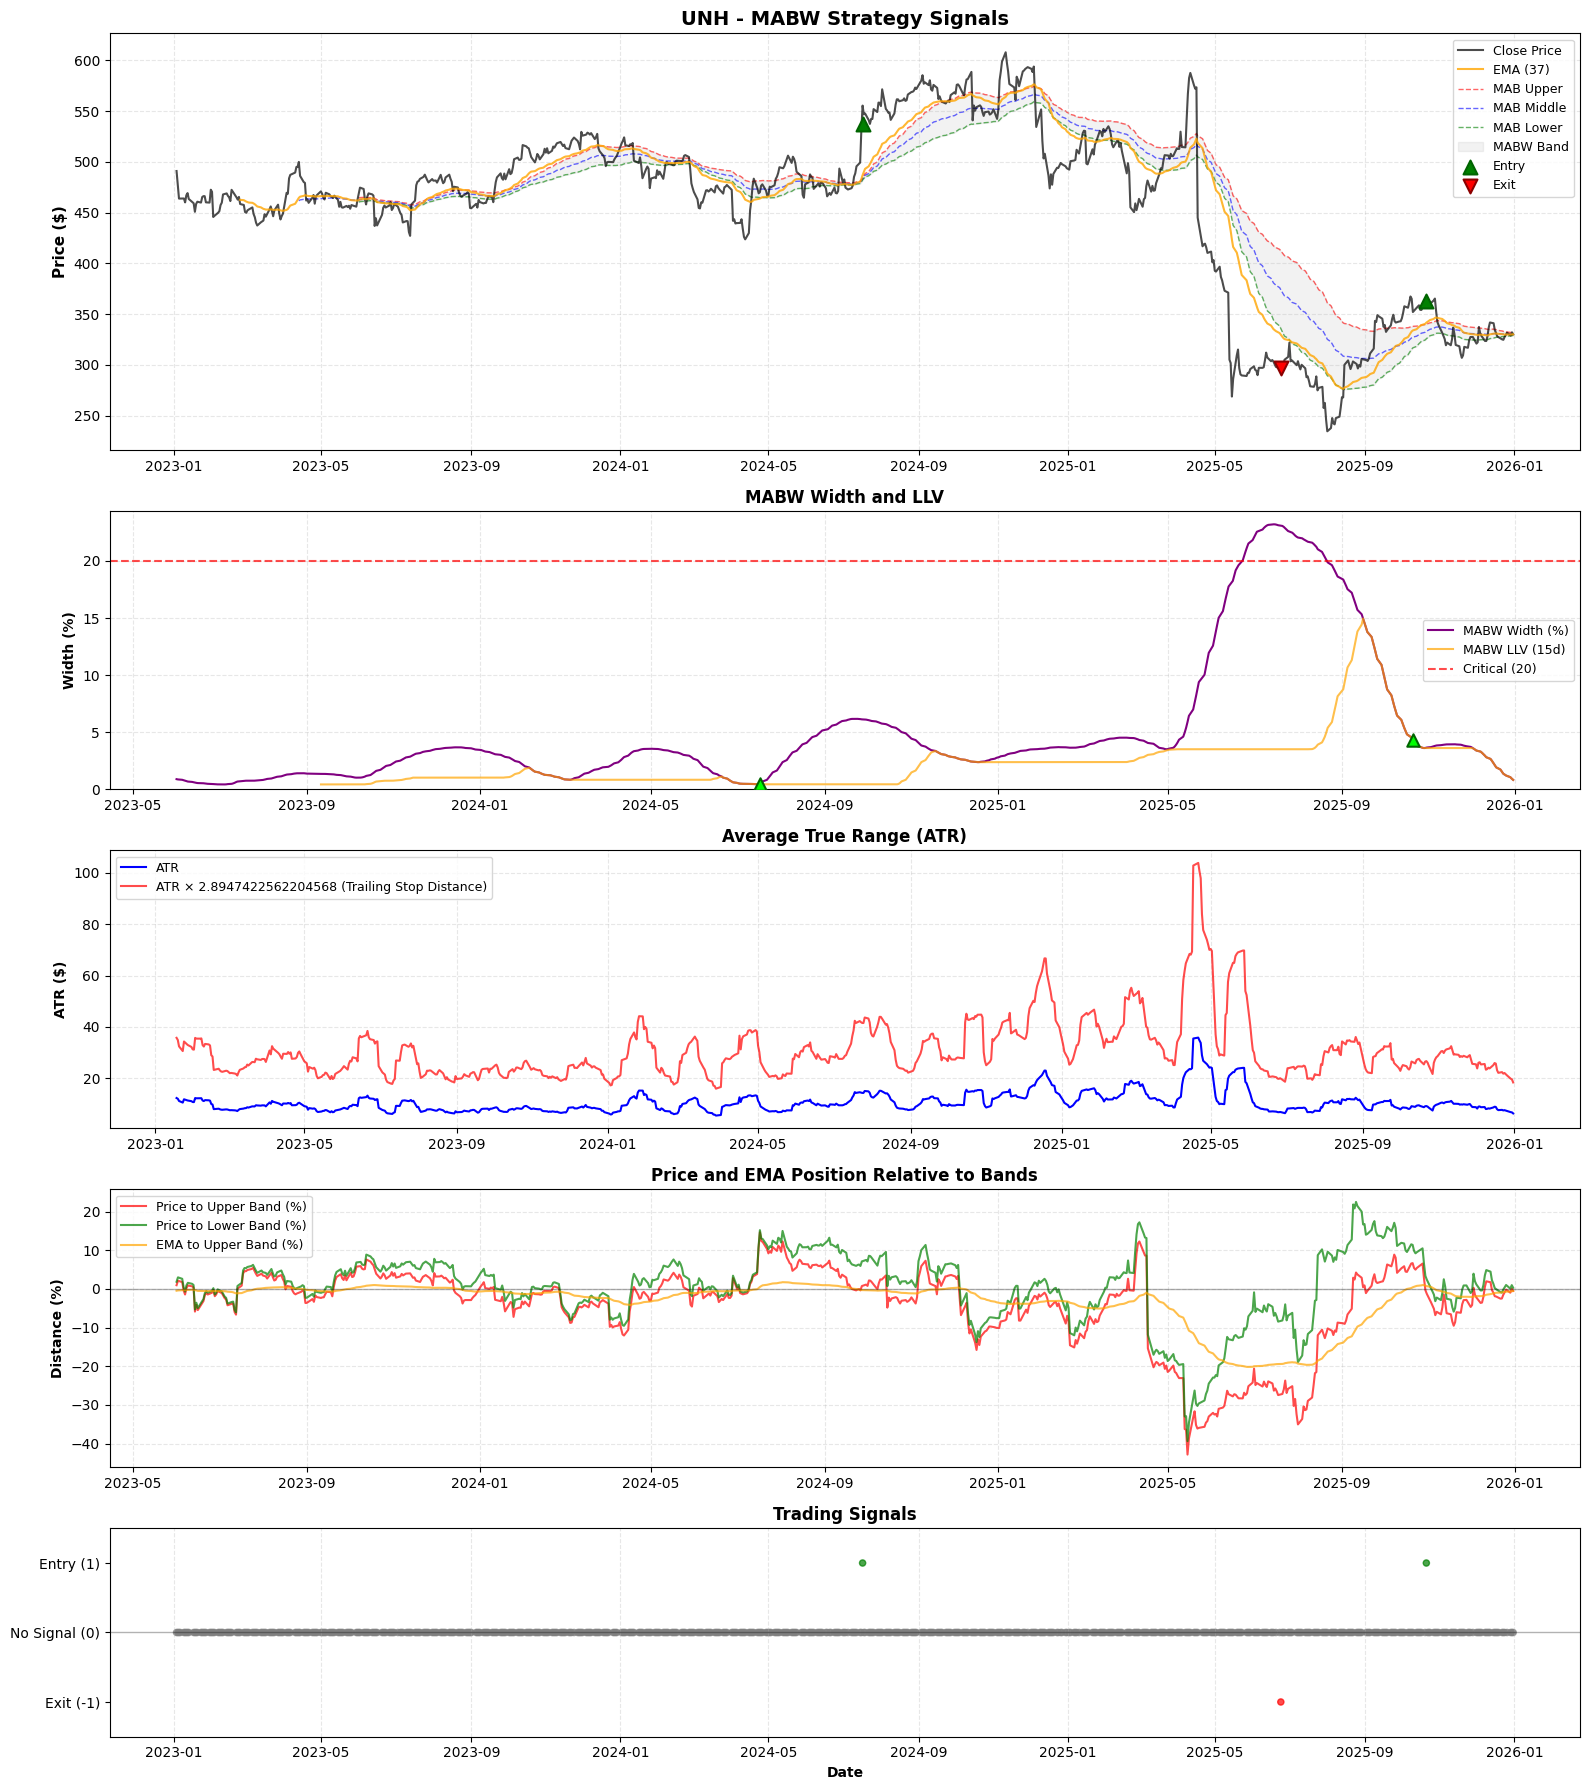


MABW Strategy Statistics for UNH:
--------------------------------------------------------------------------------
  Total Entry Signals: 2
  Total Exit Signals: 1

  Trade Performance:
    Total P&L: $-13,133.59
    Wins: 0 | Losses: 1
    Win Rate: 0.0%
    Avg Loss: $-13,133.59

MABW STRATEGY SIGNALS FOR AXP
Period: 2023-01-01 to 2025-12-31


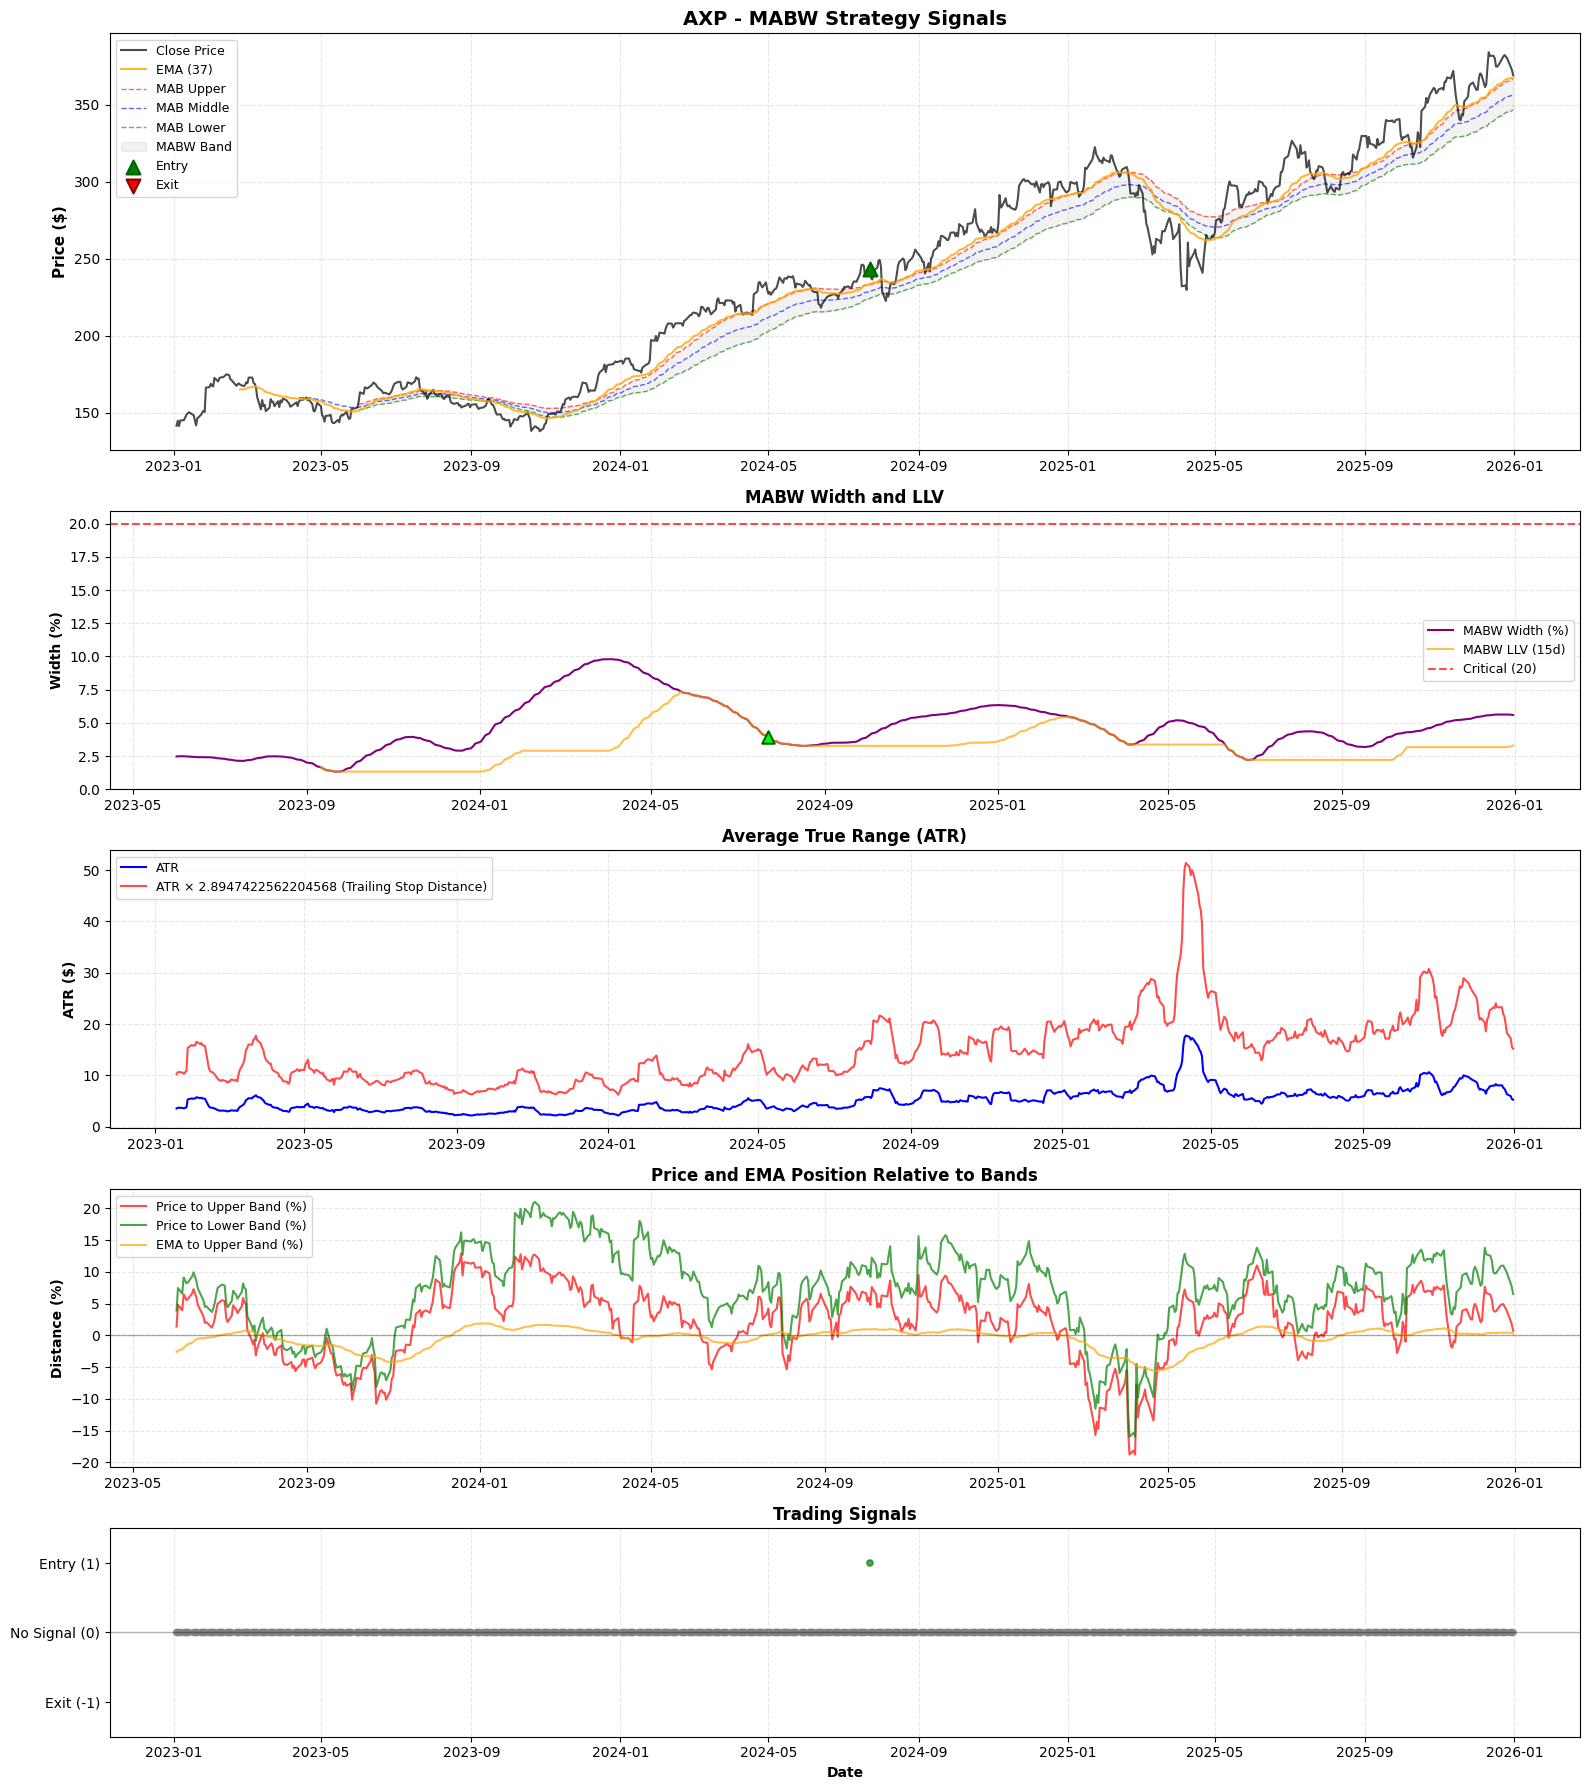


MABW Strategy Statistics for AXP:
--------------------------------------------------------------------------------
  Total Entry Signals: 1
  Total Exit Signals: 0


In [34]:
for ticker in prepared_data.keys():
    plot_mabw_signals(
        data=prepared_data[ticker],
        ticker=ticker,
        results=results,
        start_date='2023-01-01',
        end_date='2025-12-31',
        strategy_config=strategy_config
    )
